In [1]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(6)
tf.config.threading.set_inter_op_parallelism_threads(6)


In [2]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [3]:


from tensorflow import keras
from keras import layers
import time

dataset = []
labels = []
extension_dataset = []
flexion_dataset = []
rest_dataset = []
for filename in os.listdir('formated_data'):
    filepath = os.path.join('formated_data', filename)
    data = scipy.io.loadmat(filepath)
    data.pop('__header__')
    data.pop('__version__')
    data.pop('__globals__')
    

    data_arr = np.array(data['data'])
    
    data_arr = data_arr.T
    if 'EXTENSION' in filename:
        extension_dataset.append(data_arr)
    if 'FLEXION' in filename:
        flexion_dataset.append(data_arr)
    if 'REST' in filename:
        rest_dataset.append(data_arr)



In [4]:
def read_data(dataset):
    for i in range(len(dataset)):
        #dataset[i] = np.resize(dataset[i],(7,16384))
        d = dataset[i].astype(float)
        dataset[i] = mne.filter.filter_data(d, l_freq=20, h_freq=450,sfreq=2000)
        print(d.shape)

    dataset = np.array(dataset)
    print(dataset.shape)
    return dataset


In [5]:
extension_dataset[0].shape

(4, 12000)

In [6]:

#chan_names = ['Fp1','AF7','AF3','AFz','F7','F5','F3','F1','Fz','FT7','FC5','FC3','FC1','T7','C5','C3','C1','Cz','TP7','CP5','CP3','CP1','CPz','P7','P5','P3','P1','Pz','PO7','PO3','POz','Fp2','AF4','AF8','F2','F4','F6','F8','FC2','FC4','FC6','FT8','C2','C4','C6','T8','CP2','CP4','CP6','TP8','P2','P4','P6','P8','PO4','PO8','O1','Oz','O2','Iz']
chan_names = ['ECR','FCR','ECU','FCU']
info = mne.create_info(ch_names=chan_names, ch_types=['emg']*4, sfreq=2000)
info.set_montage('standard_1020')
print(info)

<Info | 8 non-empty values
 bads: []
 ch_names: ECR, FCR, ECU, FCU
 chs: 4 EMG
 custom_ref_applied: False
 dig: 3 items (3 Cardinal)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 4
 projs: []
 sfreq: 2000.0 Hz
>


In [7]:
%%capture

extension_epochs = mne.EpochsArray(data=read_data(extension_dataset), info=info)
flexion_epochs = mne.EpochsArray(data=read_data(flexion_dataset), info=info)
rest_epochs = mne.EpochsArray(data=read_data(rest_dataset), info=info)
# extension_epochs1 = mne.EpochsArray(data=(extension_dataset), info=info)
# flexion_epochs1 = mne.EpochsArray(data=(flexion_dataset), info=info)
# rest_epochs1 = mne.EpochsArray(data=(rest_dataset), info=info)

(200, 4, 12000)
(200, 4, 12000)
(200, 4, 12000)
________________________________  1
flexion


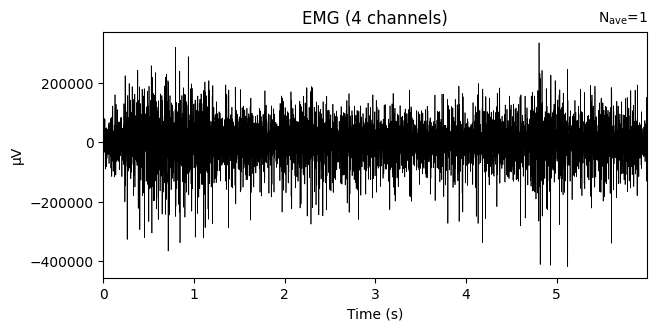

________________________________ 
________________________________  2
rest


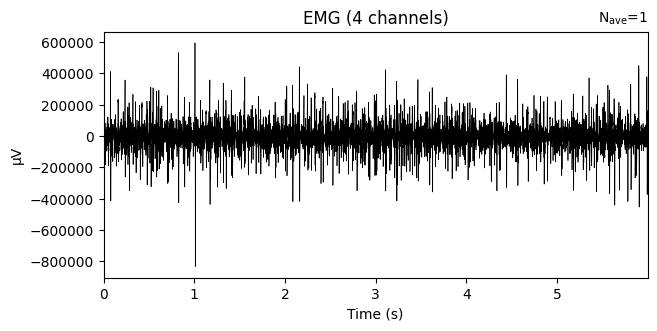

________________________________ 
________________________________  3
extension


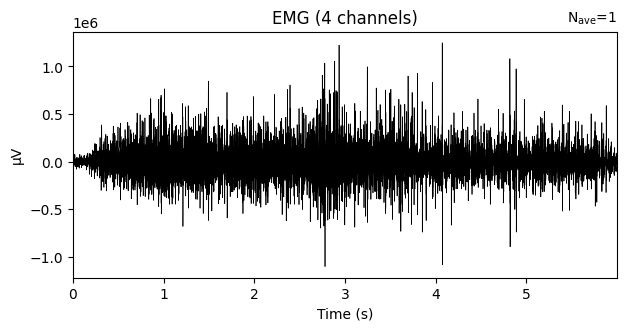

________________________________ 
________________________________  4
extension


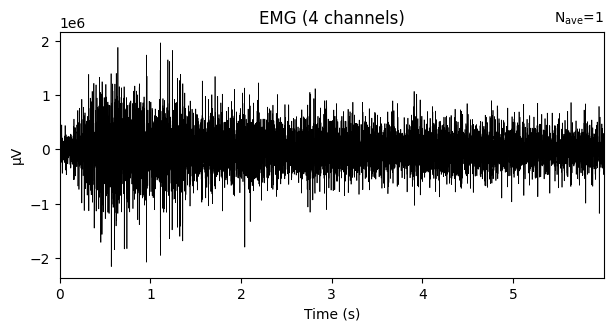

________________________________ 
________________________________  5
rest


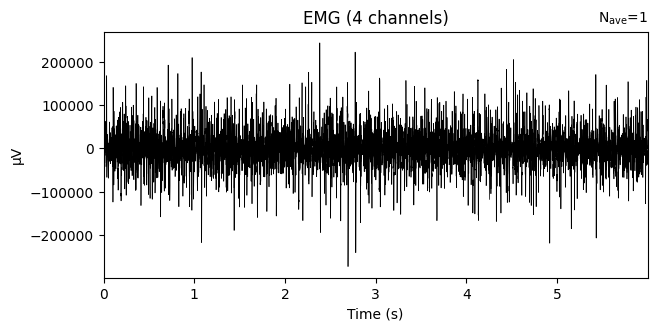

________________________________ 
________________________________  6
extension


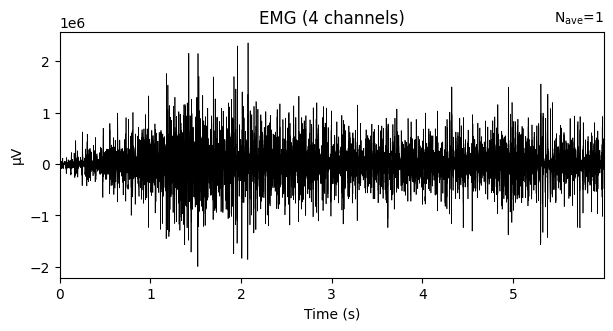

________________________________ 
________________________________  7
rest


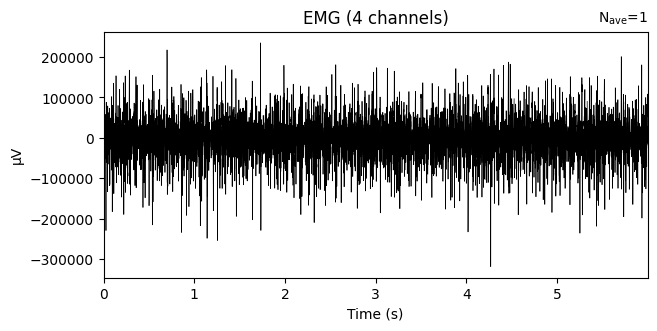

________________________________ 
________________________________  8
extension


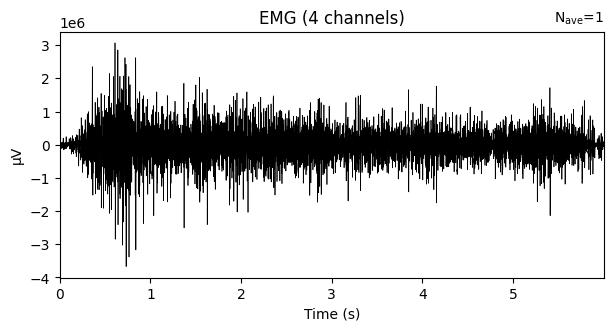

________________________________ 
________________________________  9
flexion


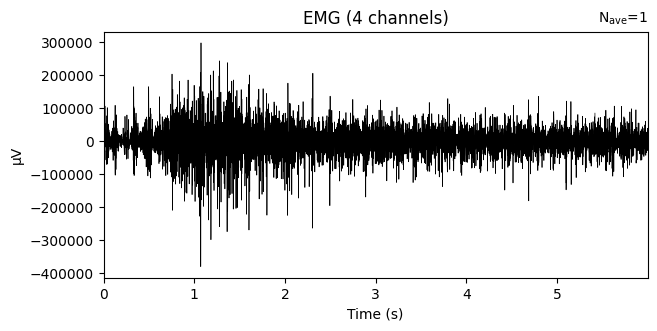

________________________________ 
________________________________  10
rest


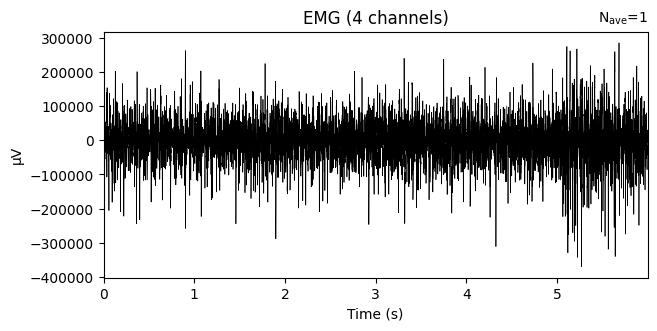

________________________________ 


In [8]:
import matplotlib
from mne.time_frequency import tfr_morlet
%matplotlib inline
print(extension_epochs.get_data().shape)
print(flexion_epochs.get_data().shape)
print(rest_epochs.get_data().shape)
tmp = np.vstack((extension_epochs.get_data(),flexion_epochs.get_data(),rest_epochs.get_data()))
fs=2000

for i in range(10):
    print("________________________________ ",i+1)
    rand = random.randint(0,599)
    if(0 <= rand <= 199):
        print("extension")
    elif(200 <= rand <= 399):
        print("flexion")
    else:
        print("rest")
    
    d = tmp[rand]
    
    t_evoked = mne.EvokedArray(d, info, tmin=0)
    
    
    t_evoked.plot()
    
    print("________________________________ ")

In [9]:
import numpy as np
import pywt

def min_max_scale_signal(signal, min_val=0, max_val=1):
    """
    Scale the signal to a new range [min_val, max_val].

    Parameters:
    - signal: Input signal, a numpy array.
    - min_val: Minimum value of the scaled range.
    - max_val: Maximum value of the scaled range.

    Returns:
    - Scaled signal.
    """
    min_signal = np.min(signal)
    max_signal = np.max(signal)
    scaled_signal = (signal - min_signal) / (max_signal - min_signal) * (max_val - min_val) + min_val
    return scaled_signal


In [10]:
import scipy.io
import numpy as np
import mne
import os
import gym
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

ext_list = []
flex_list = []
rest_list = []

ext_list.append(extension_epochs.get_data())
flex_list.append(flexion_epochs.get_data())
rest_list.append(rest_epochs.get_data())
extension_labels = [0 for i in range(extension_epochs.get_data().shape[0])]
print(extension_labels)

flexion_labels = [1 for i in range(flexion_epochs.get_data().shape[0])]
print(flexion_labels)

rest_labels = [2 for i in range(rest_epochs.get_data().shape[0])]
print(rest_labels)

label_list = extension_labels + flexion_labels + rest_labels

extension_array = np.vstack(ext_list)
flexion_array = np.vstack(flex_list)
rest_array = np.vstack(rest_list)

extension_array = min_max_scale_signal(extension_array,-1,1)
flexion_array = min_max_scale_signal(flexion_array,-1,1)
rest_array = min_max_scale_signal(rest_array,-1,1)

label_array = np.hstack(label_list)

print(label_array.shape)
print(extension_array.shape,flexion_array.shape,rest_array.shape)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [11]:
import math
import pywt
import scipy.signal
from scipy import stats
def mean(x):
    return np.mean(x, axis=-1).reshape(-1, 1)

def stddev(x):
    return np.std(x, axis=-1).reshape(-1, 1)

def peaktopeak(x):
    return np.ptp(x, axis=-1).reshape(-1, 1)

def variance(x):
    return np.var(x, axis=-1).reshape(-1, 1)

def mini(x):
    return np.min(x, axis=-1).reshape(-1, 1)

def maxi(x):
    return np.max(x, axis=-1).reshape(-1, 1)

def argmini(x):
    return np.argmin(x, axis=-1).reshape(-1, 1)

def argmaxi(x):
    return np.argmax(x, axis=-1).reshape(-1, 1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1)).reshape(-1, 1)

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1).reshape(-1, 1)

def skewness(x):
    return stats.skew(x, axis=-1).reshape(-1, 1)

def kurtosis(x):
    return stats.kurtosis(x, axis=-1).reshape(-1, 1)

def concat_features(x):
    features = np.concatenate(
        (
            peaktopeak(x),
            rms(x),
            abs_diff_signal(x),
            skewness(x),
            kurtosis(x),
            variance(x),
            mean(x),
            stddev(x)
        ),
        axis=1
    )
    return features


    
def featuresarray_load(data_array):
    features = []
    fs = 2000
    for d in data_array:
        
        beta_ftrs = concat_features(d)
        
        _,p=scipy.signal.welch(d, fs=fs,average='median')
        
        res = np.concatenate((beta_ftrs,p),axis=1)
        
        features.append(res)
    return np.array(features)

In [12]:
f_ext = featuresarray_load(extension_array)
f_flex = featuresarray_load(flexion_array)
f_rest = featuresarray_load(rest_array)

np.save("ext_features_array.npy",allow_pickle=False,arr=f_ext)
np.save("flex_features_array.npy",allow_pickle=False,arr=f_flex)
np.save("rest_features_array.npy",allow_pickle=False,arr=f_rest)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
import random
import matplotlib.pyplot as plt

(600, 4, 137)
137
(480, 4, 137)
(120, 4, 137)
(480,)
(120,)
160 160 160 137
40 40 40 137


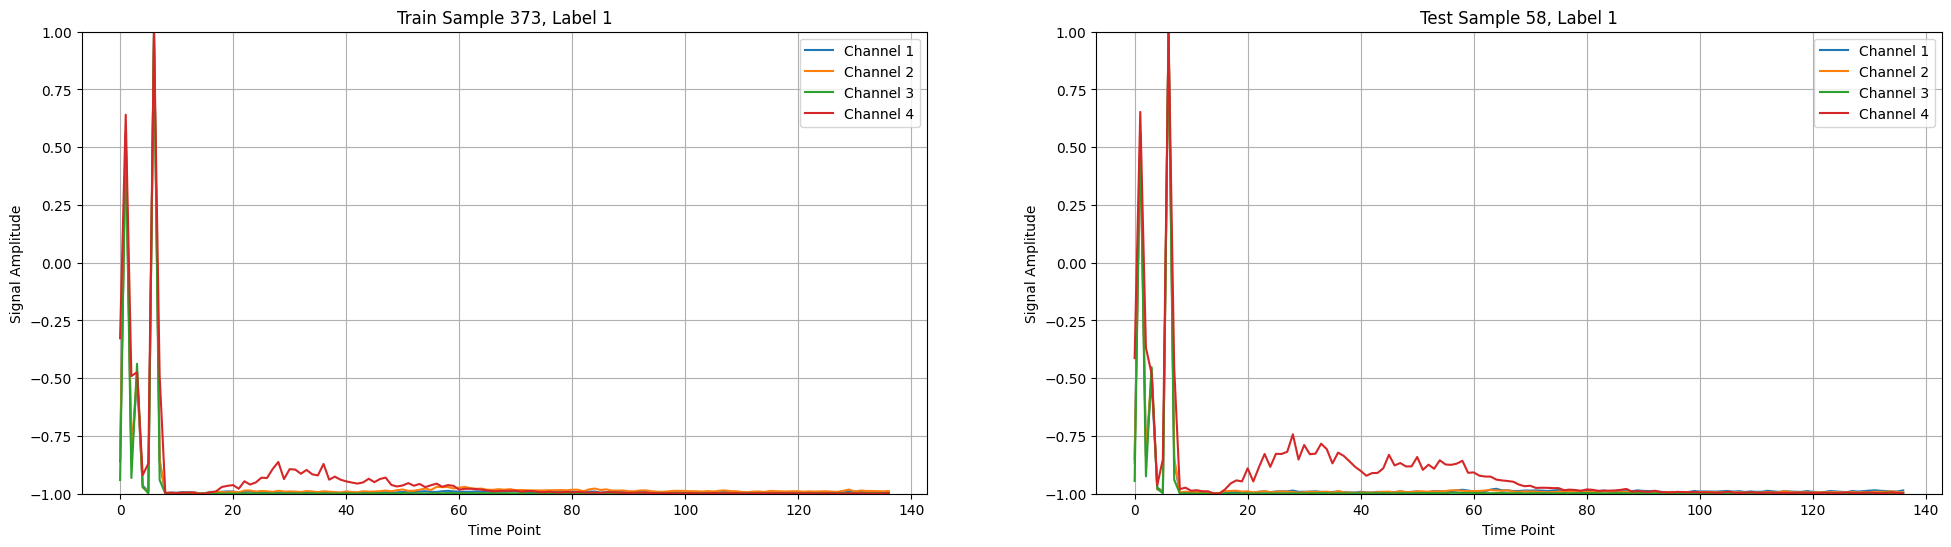

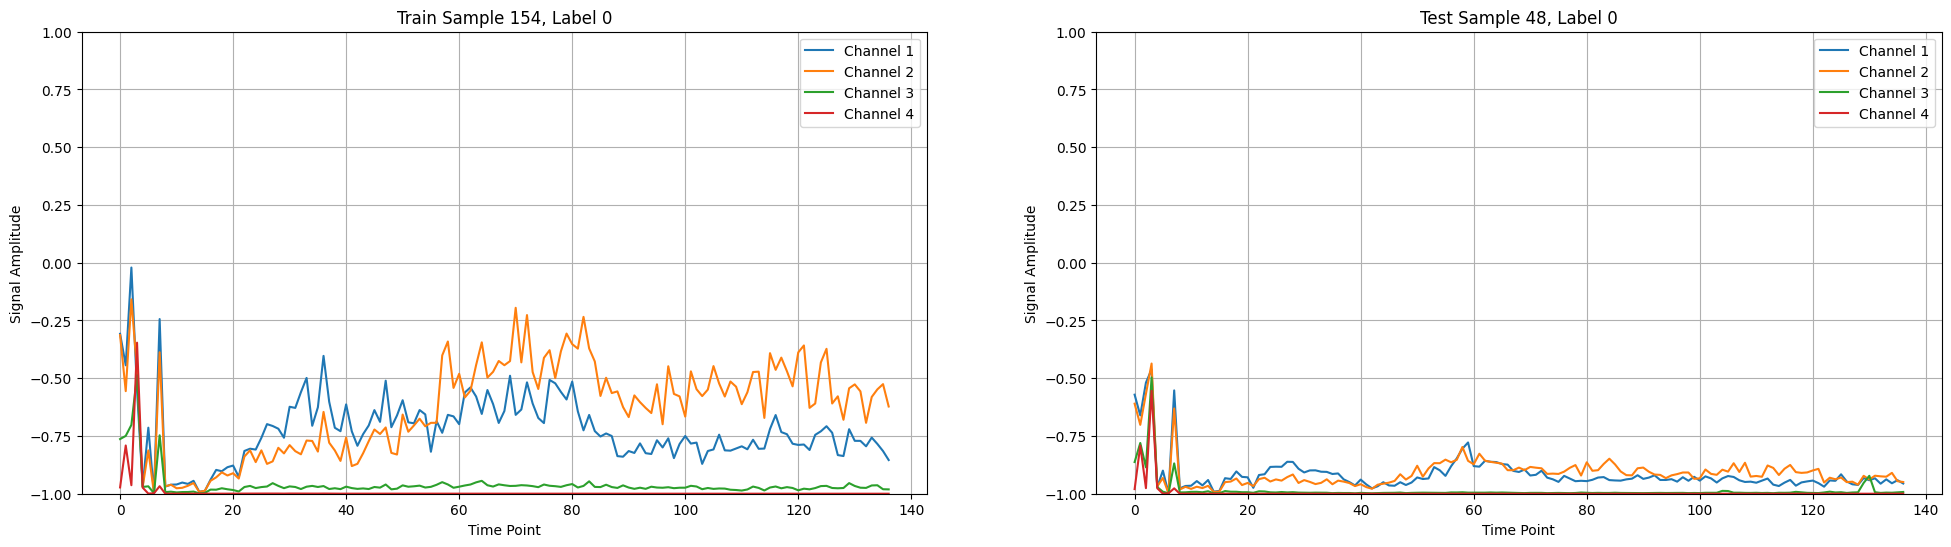

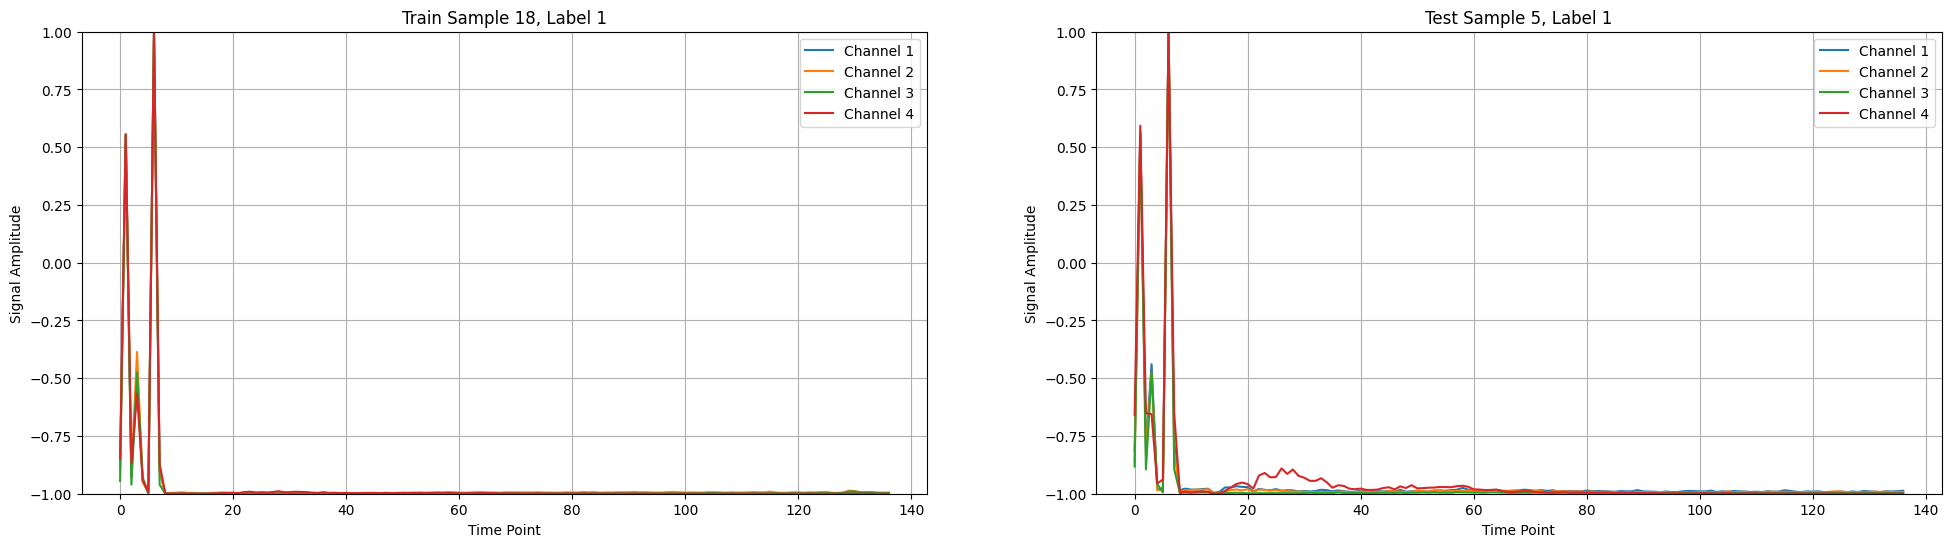

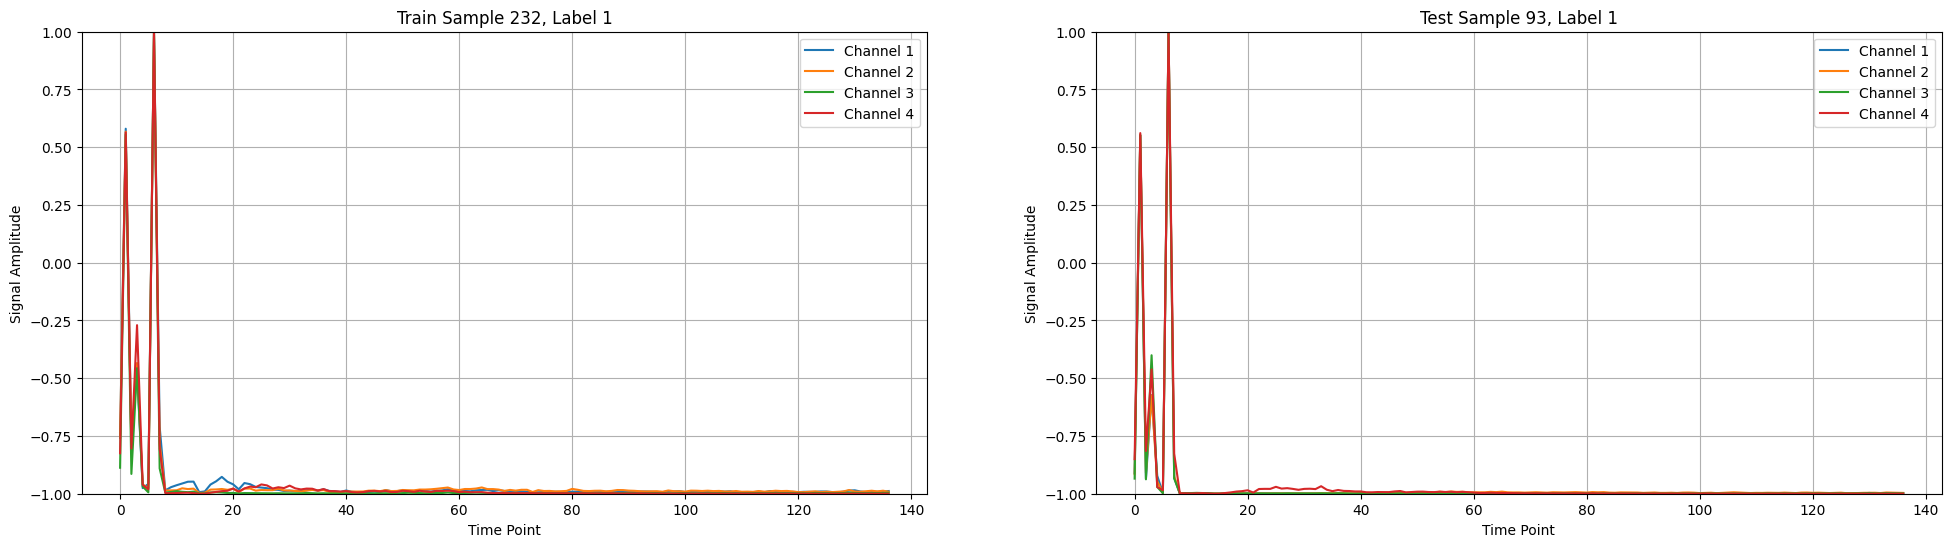

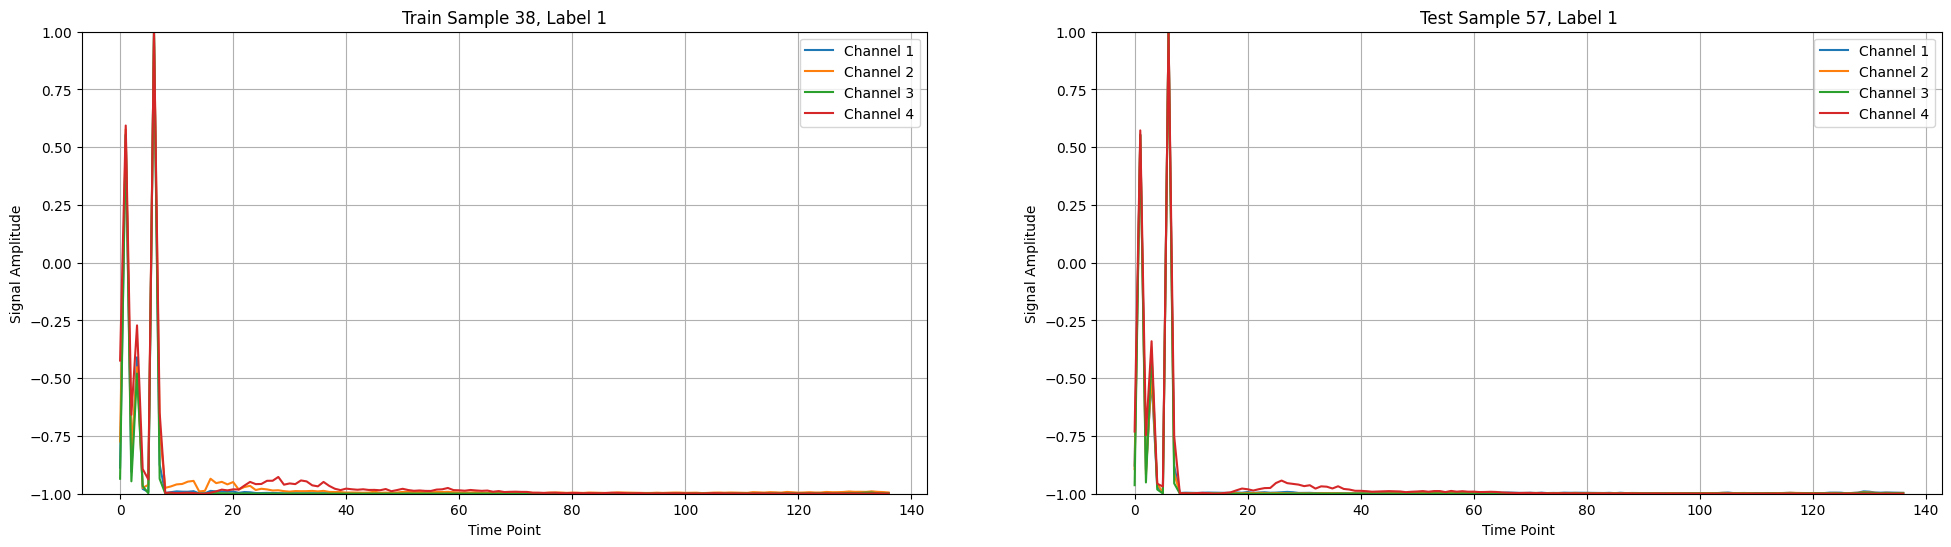

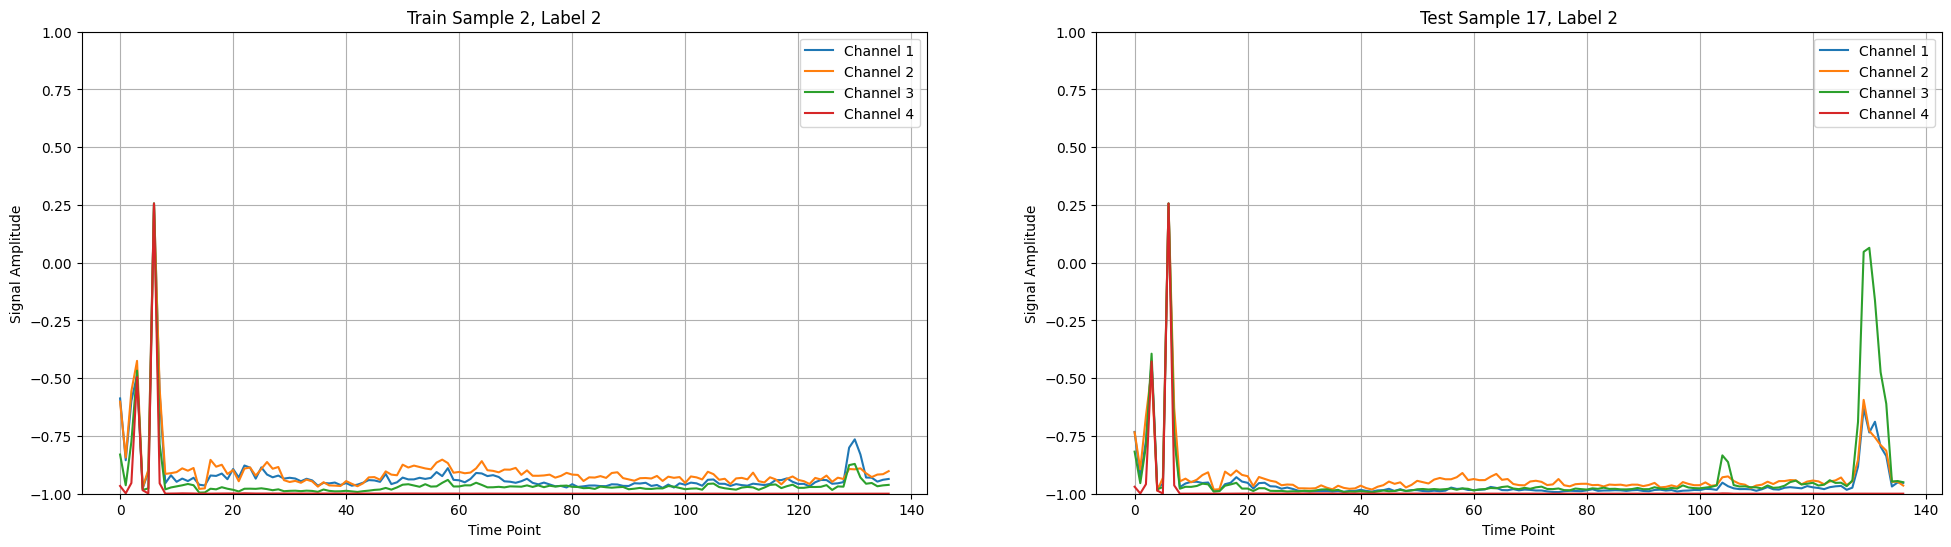

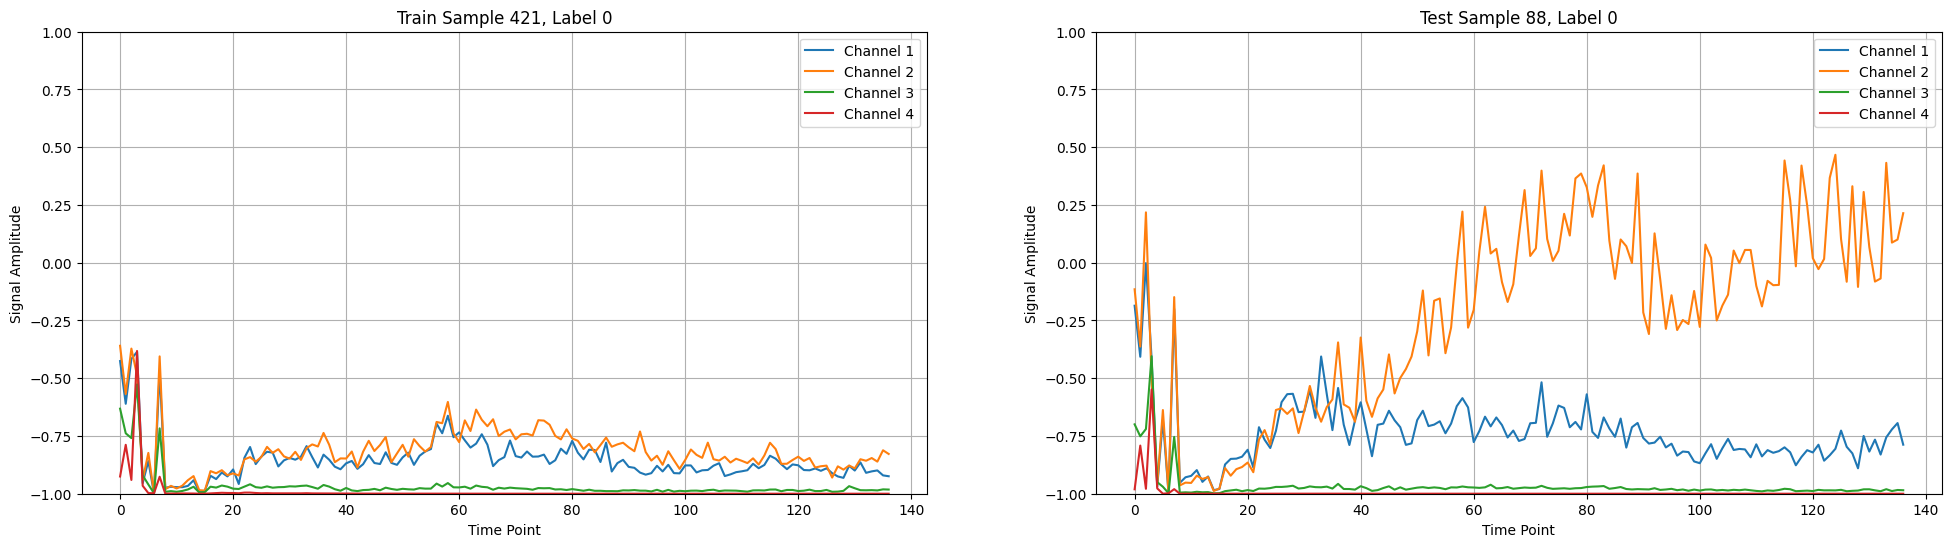

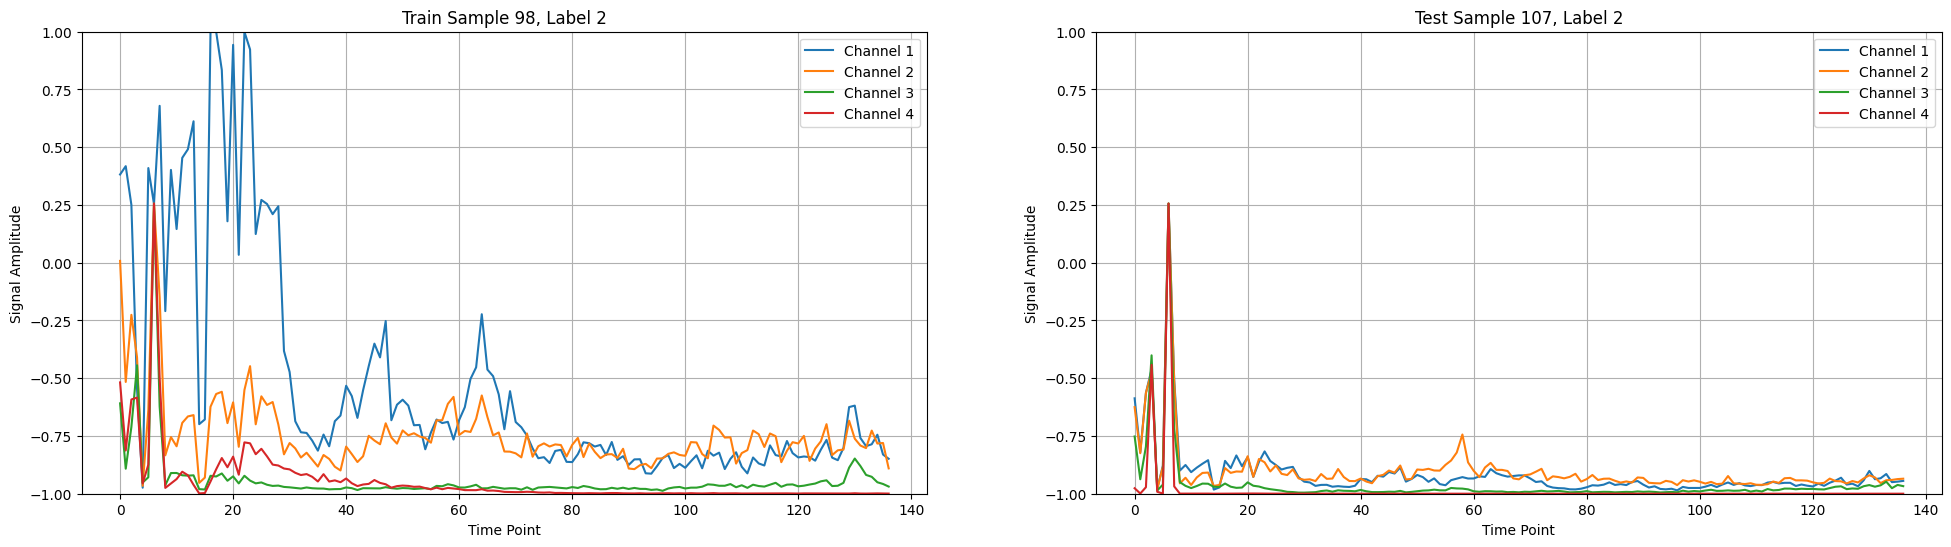

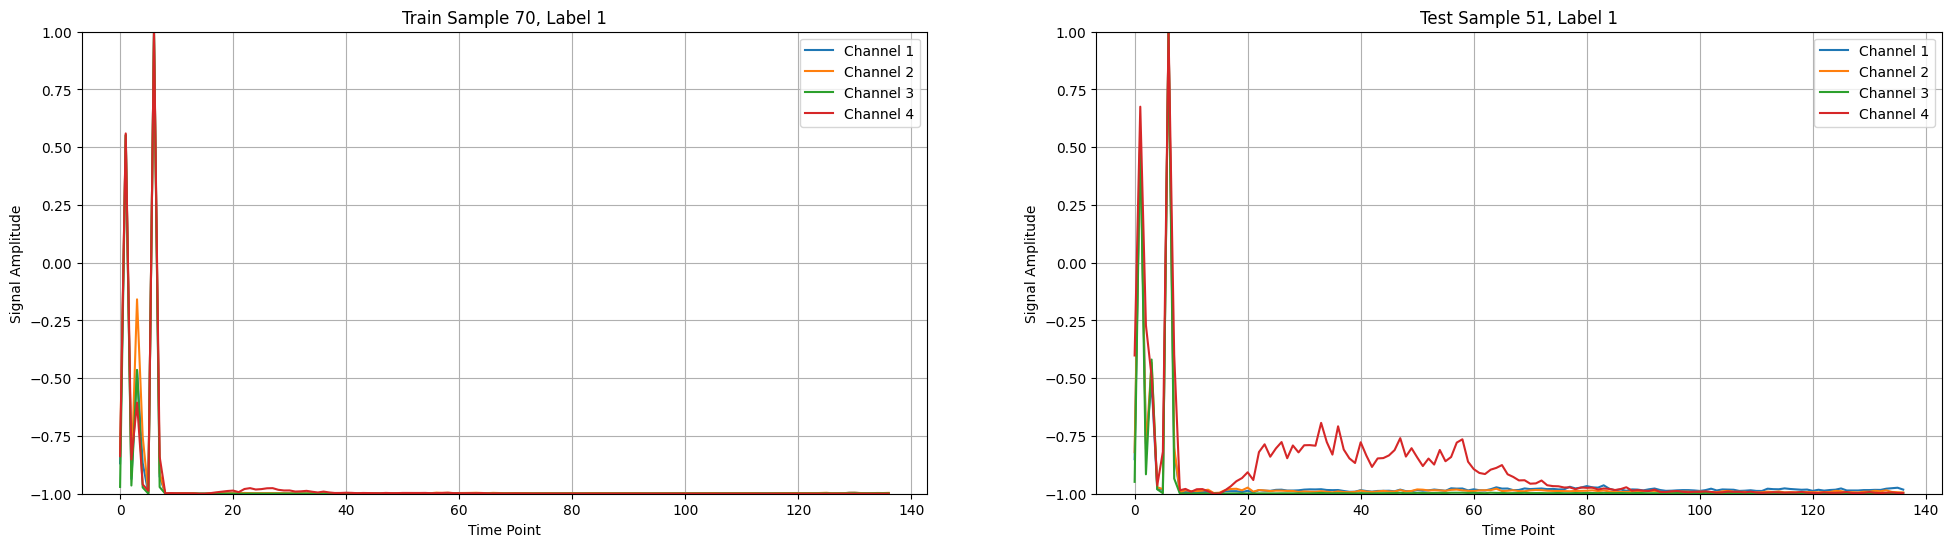

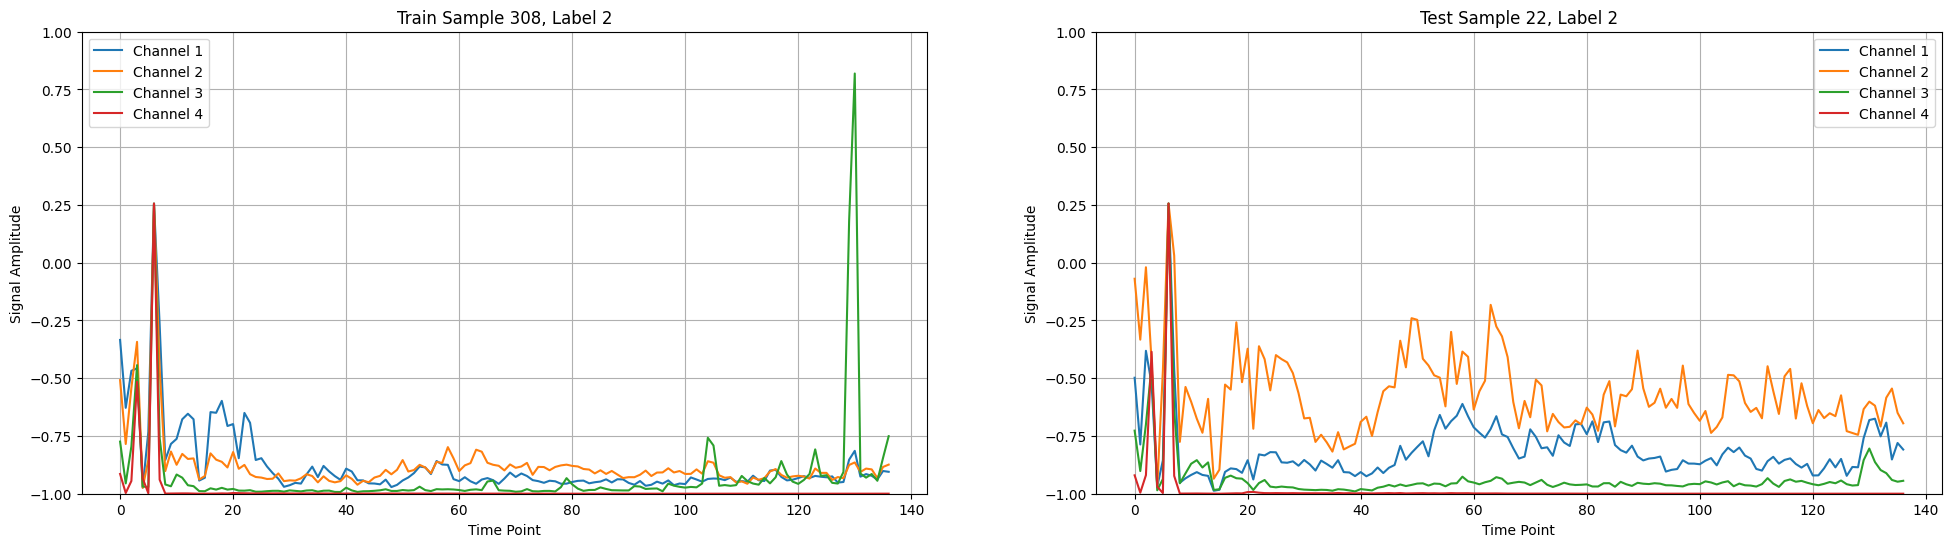

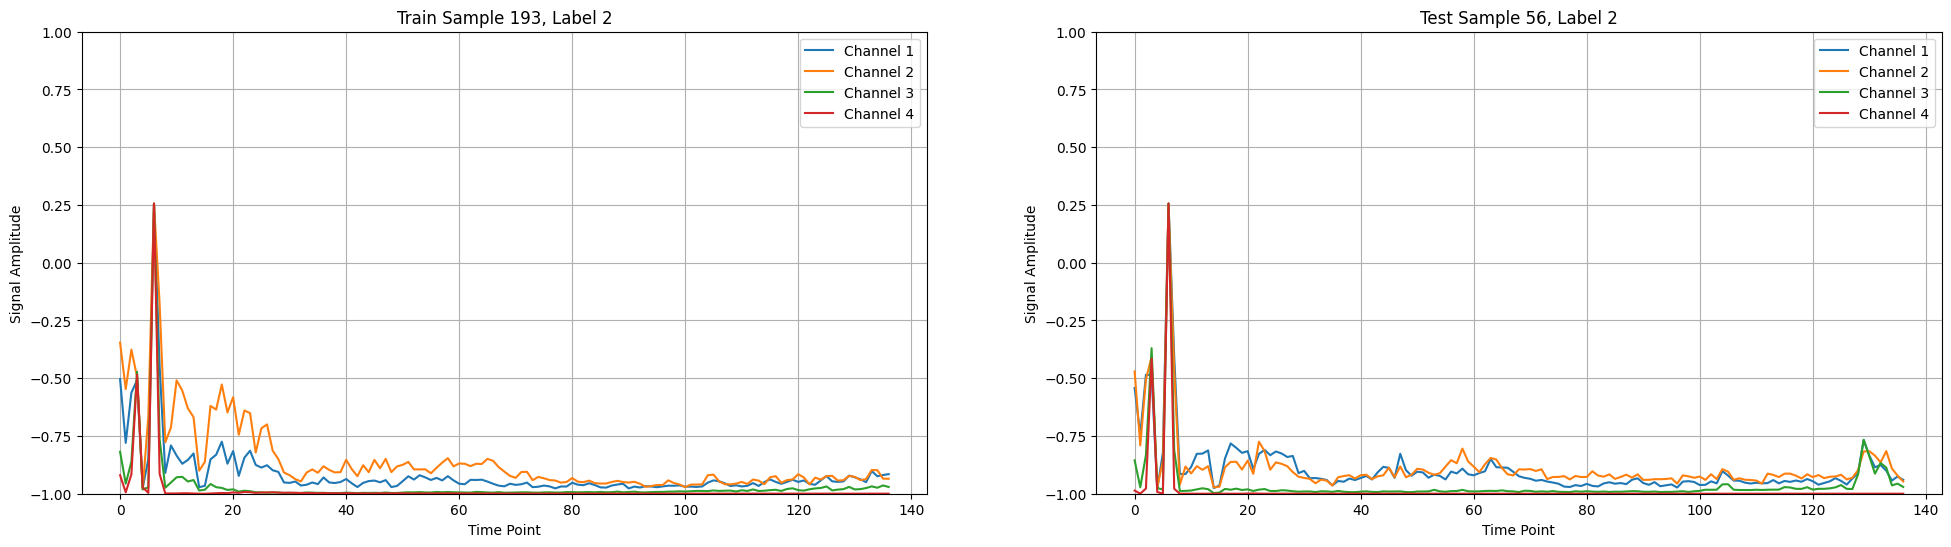

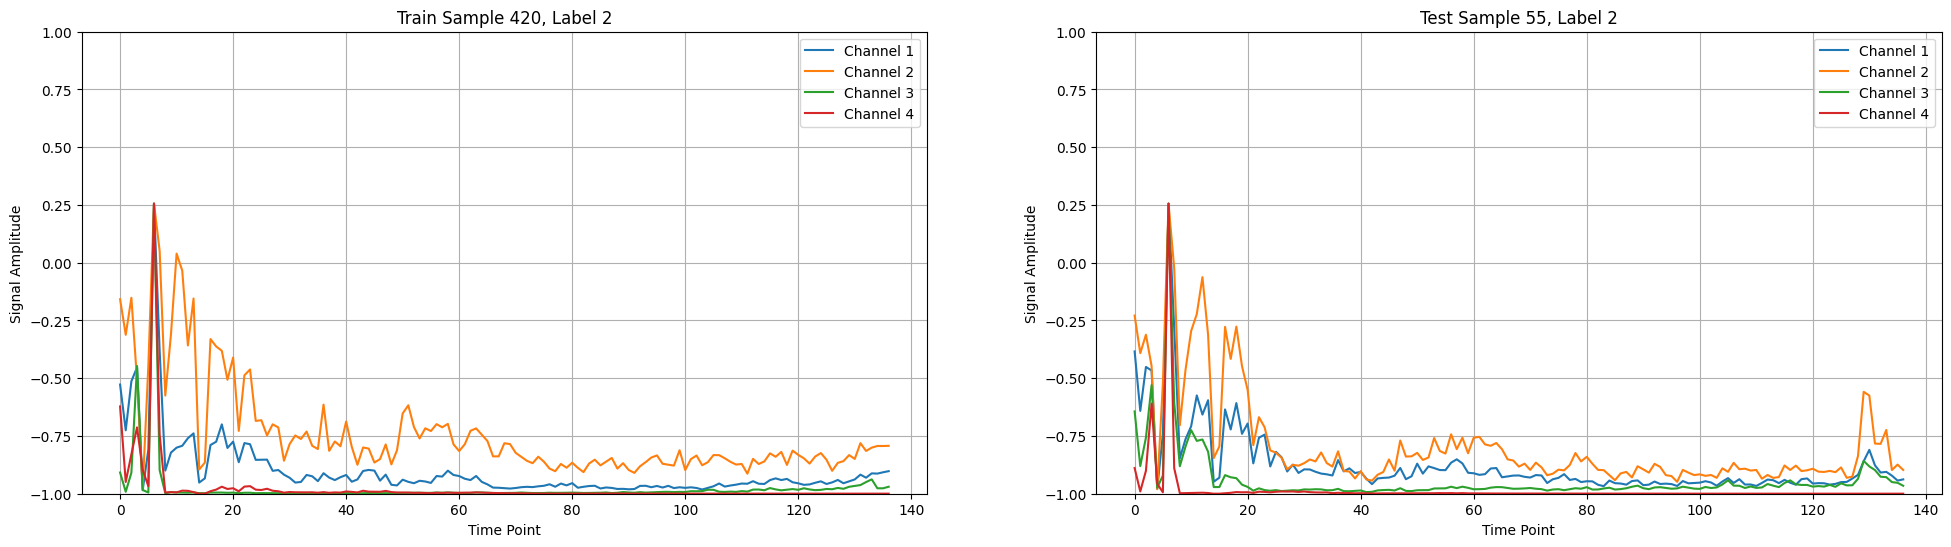

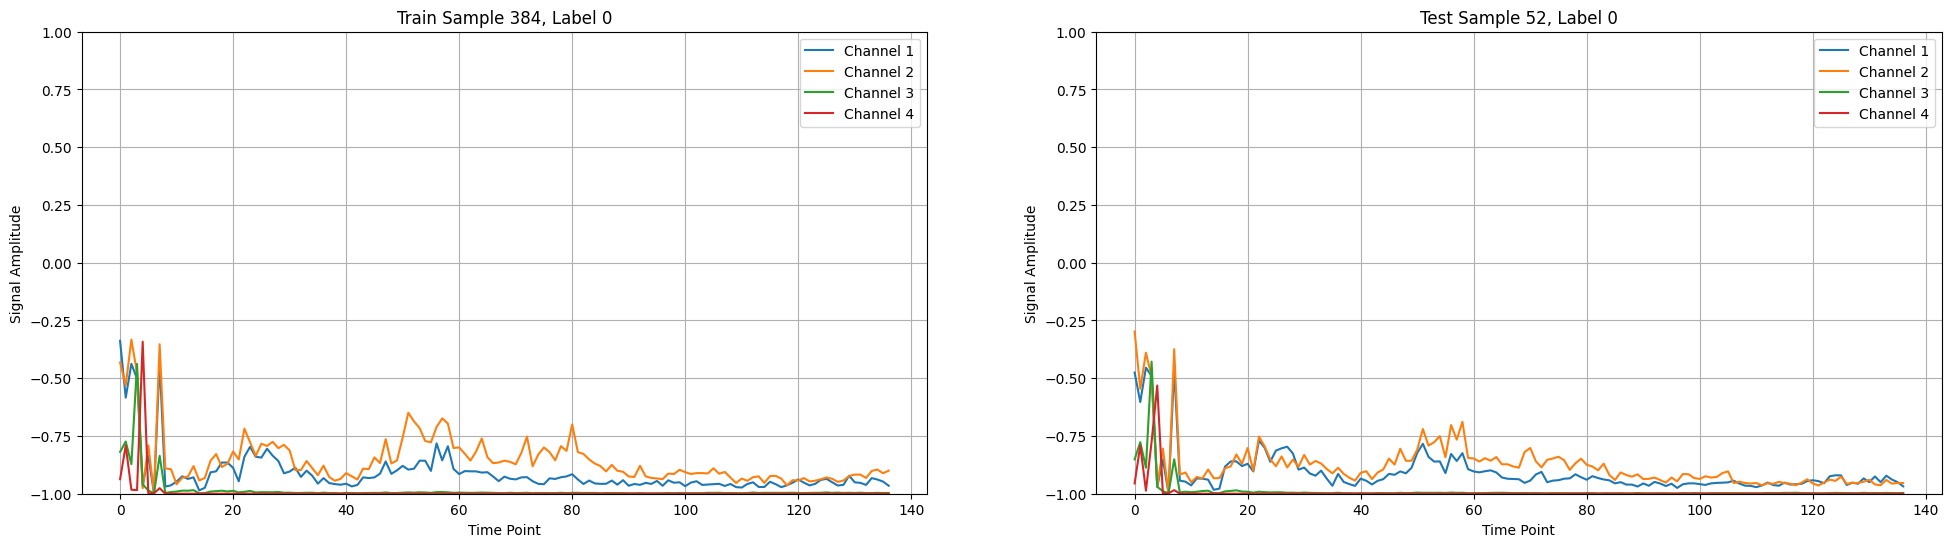

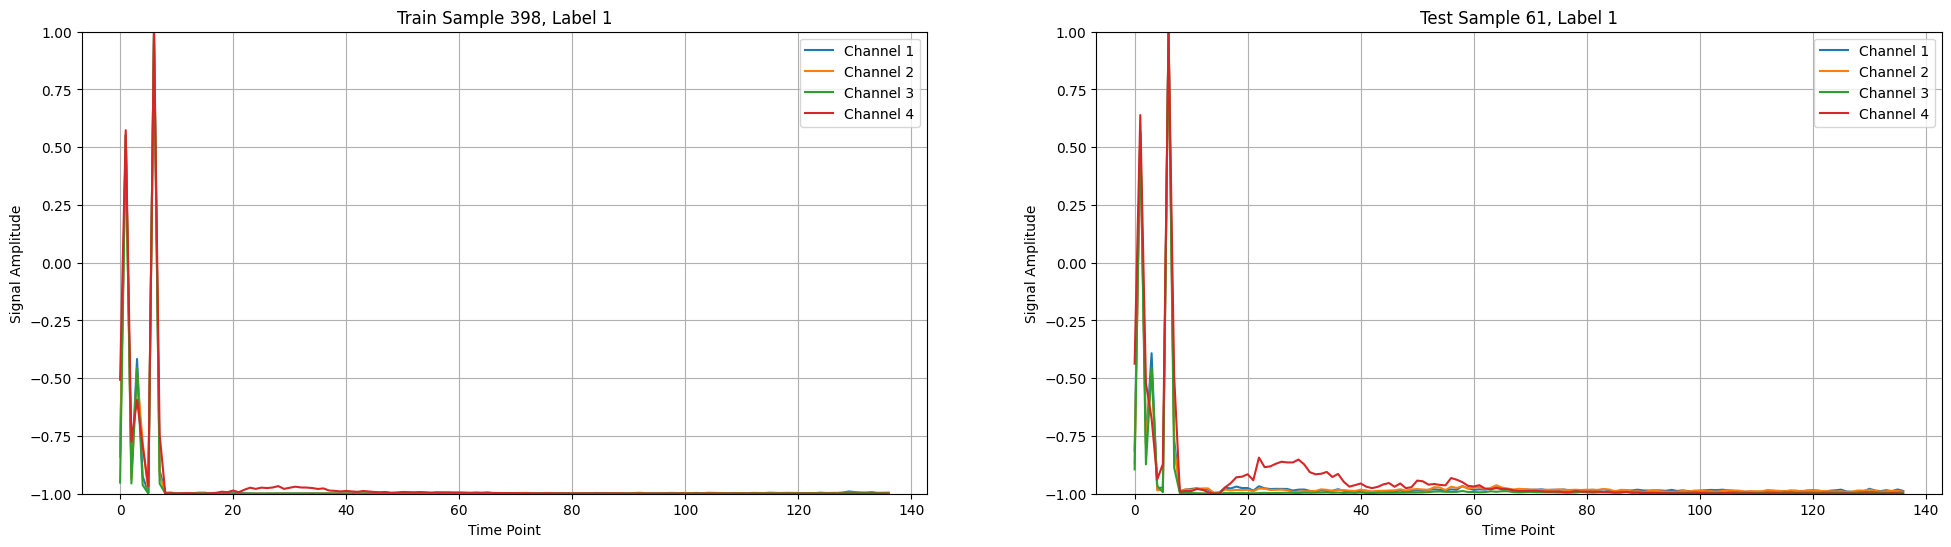

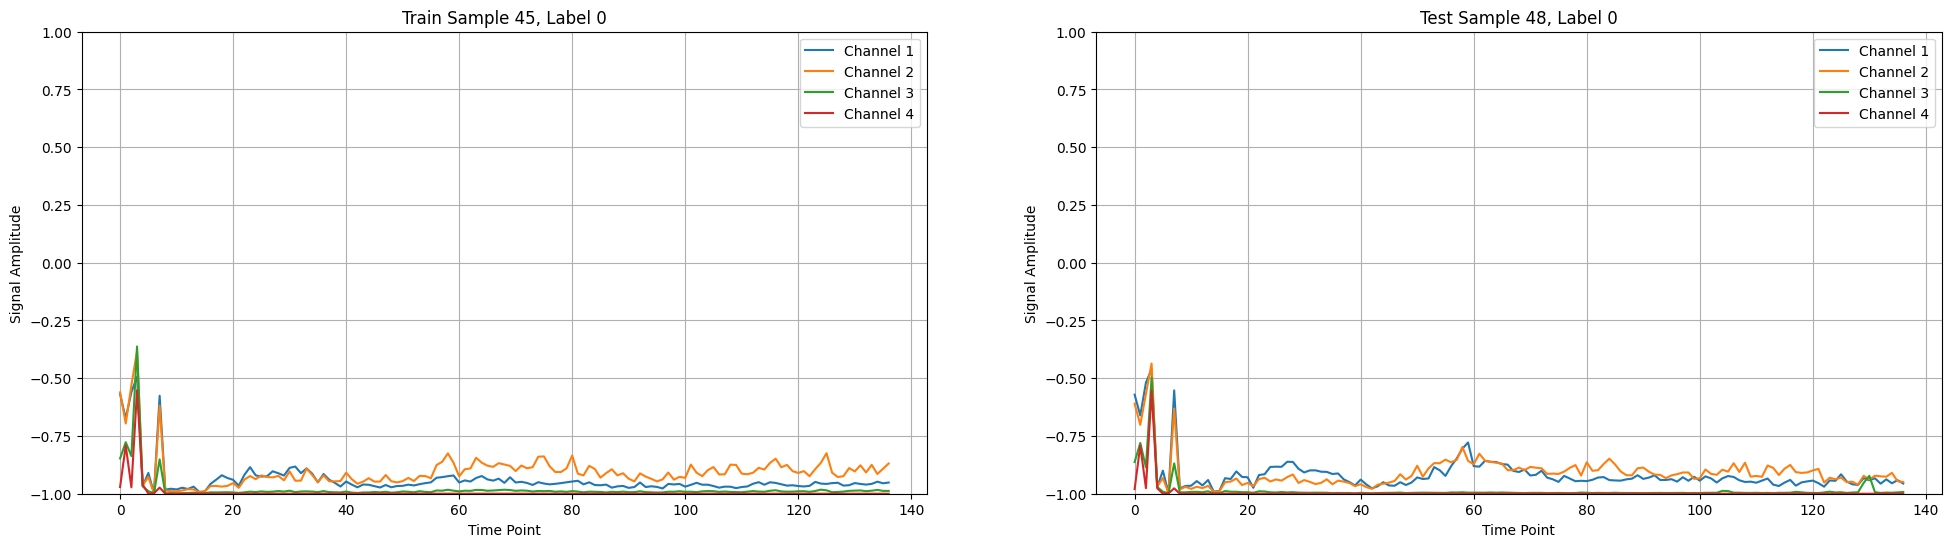

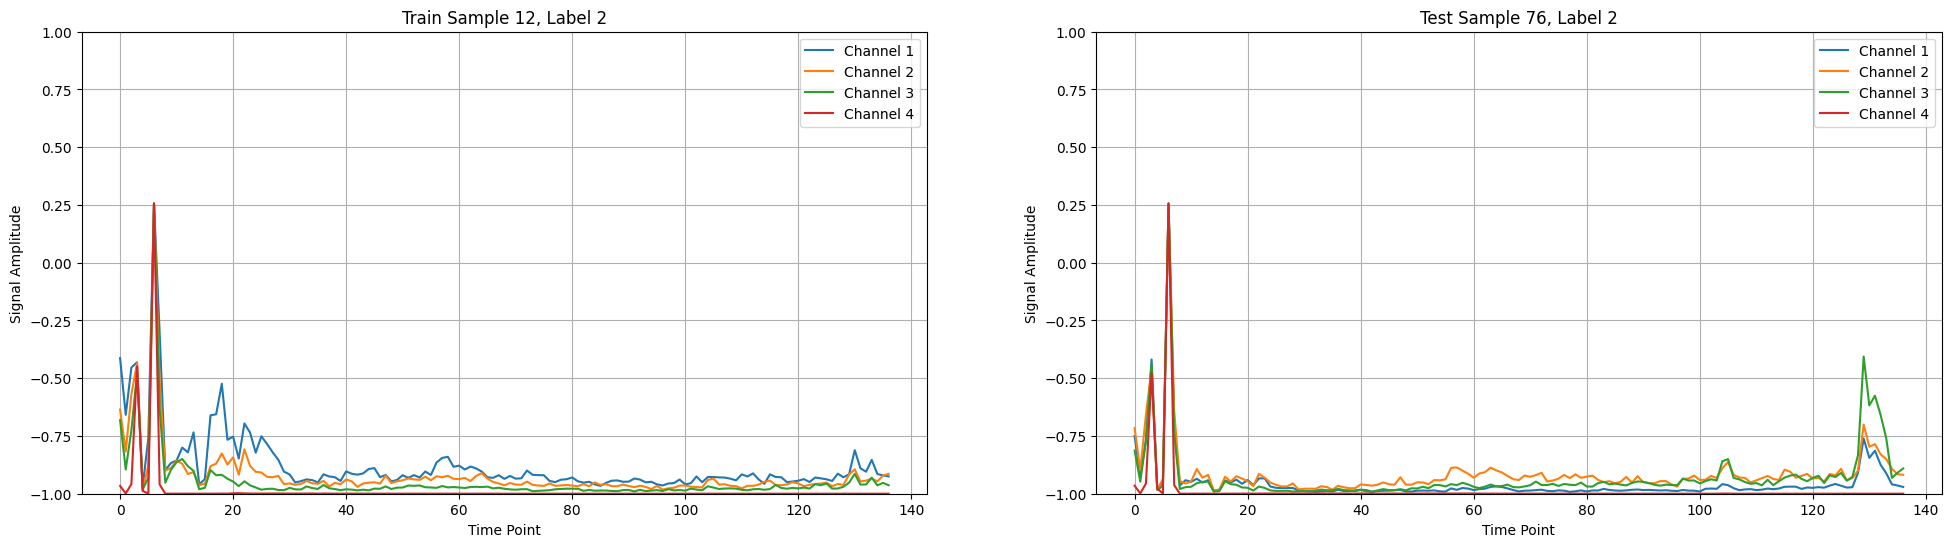

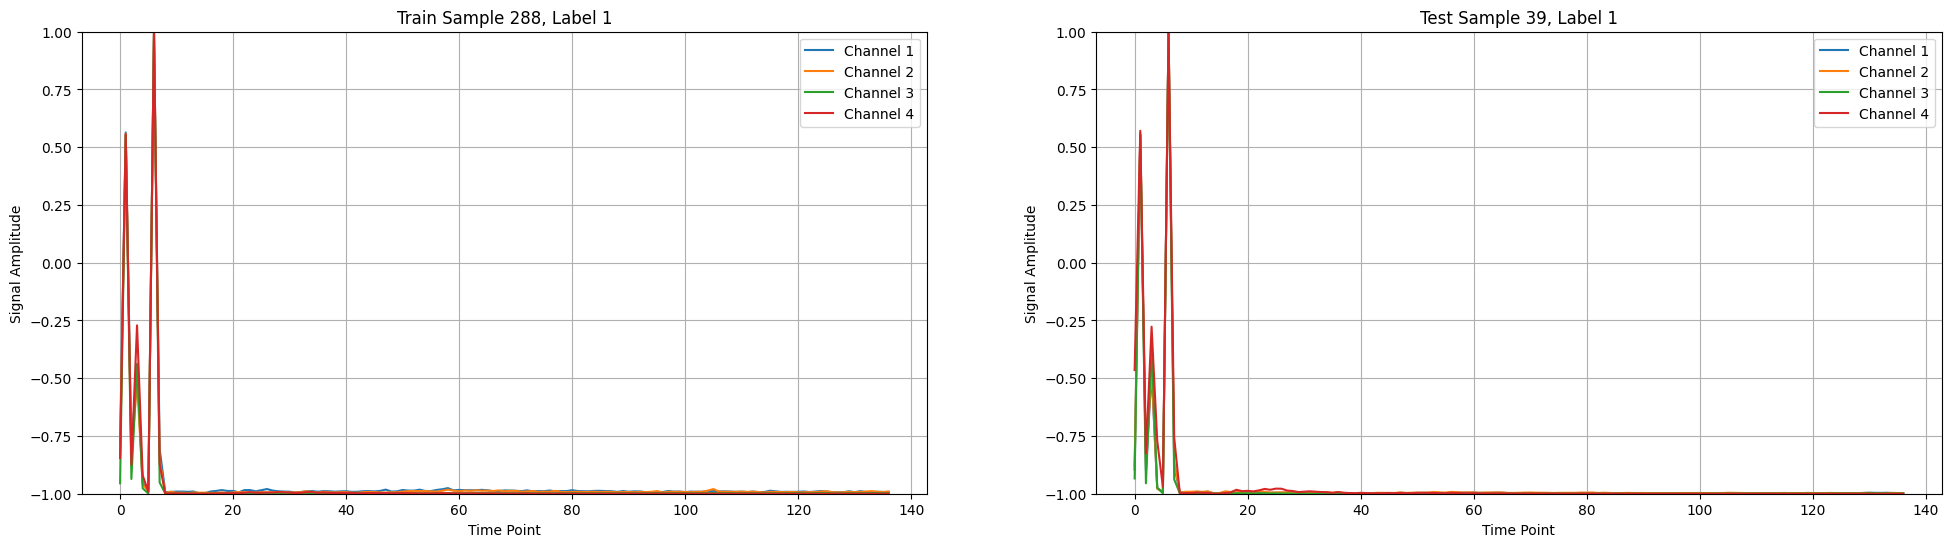

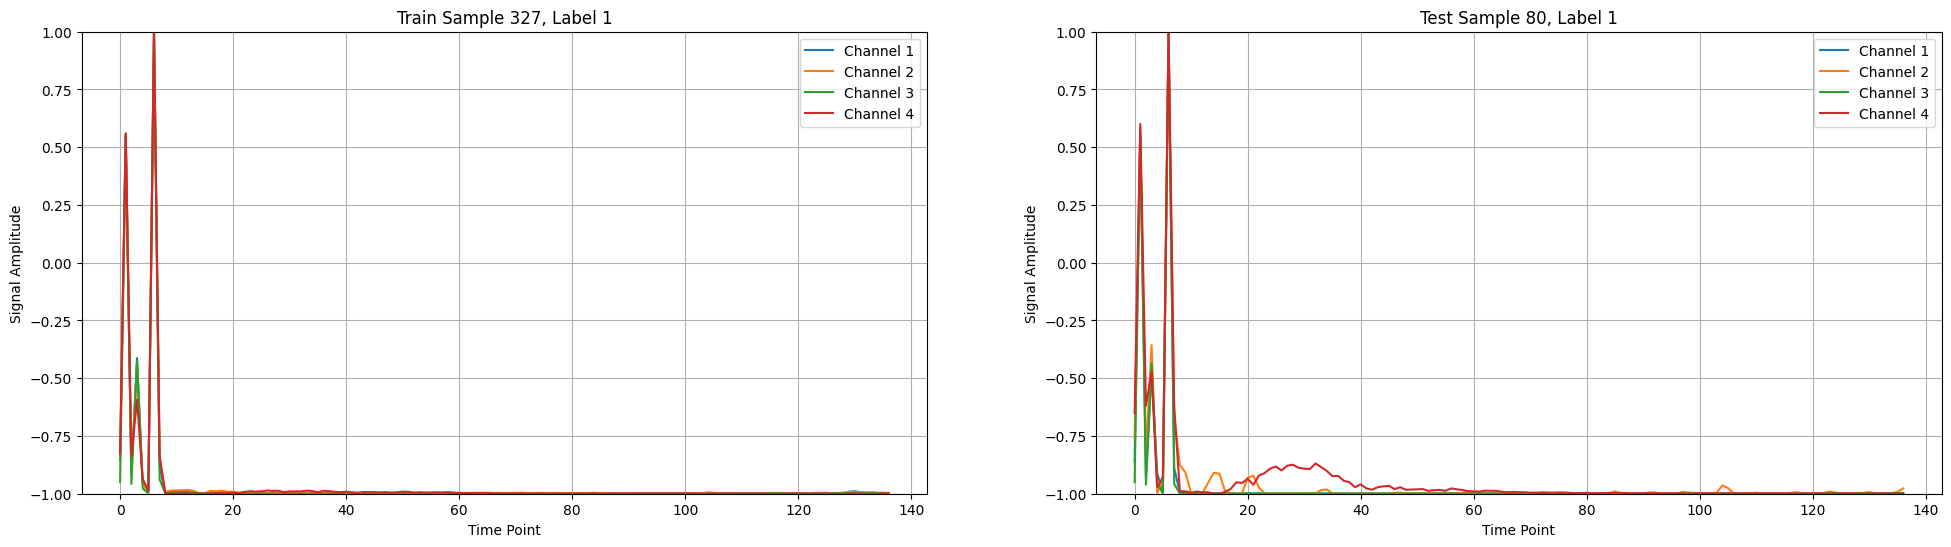

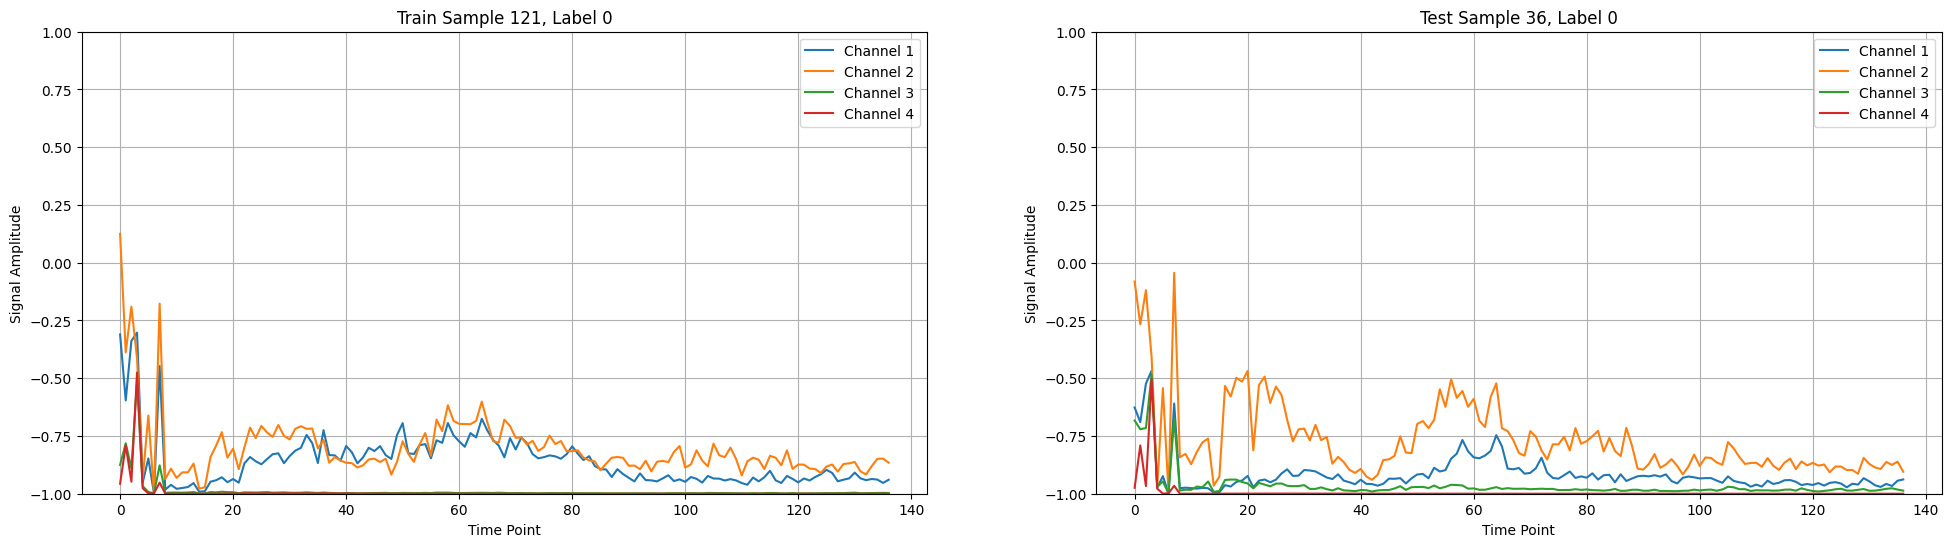

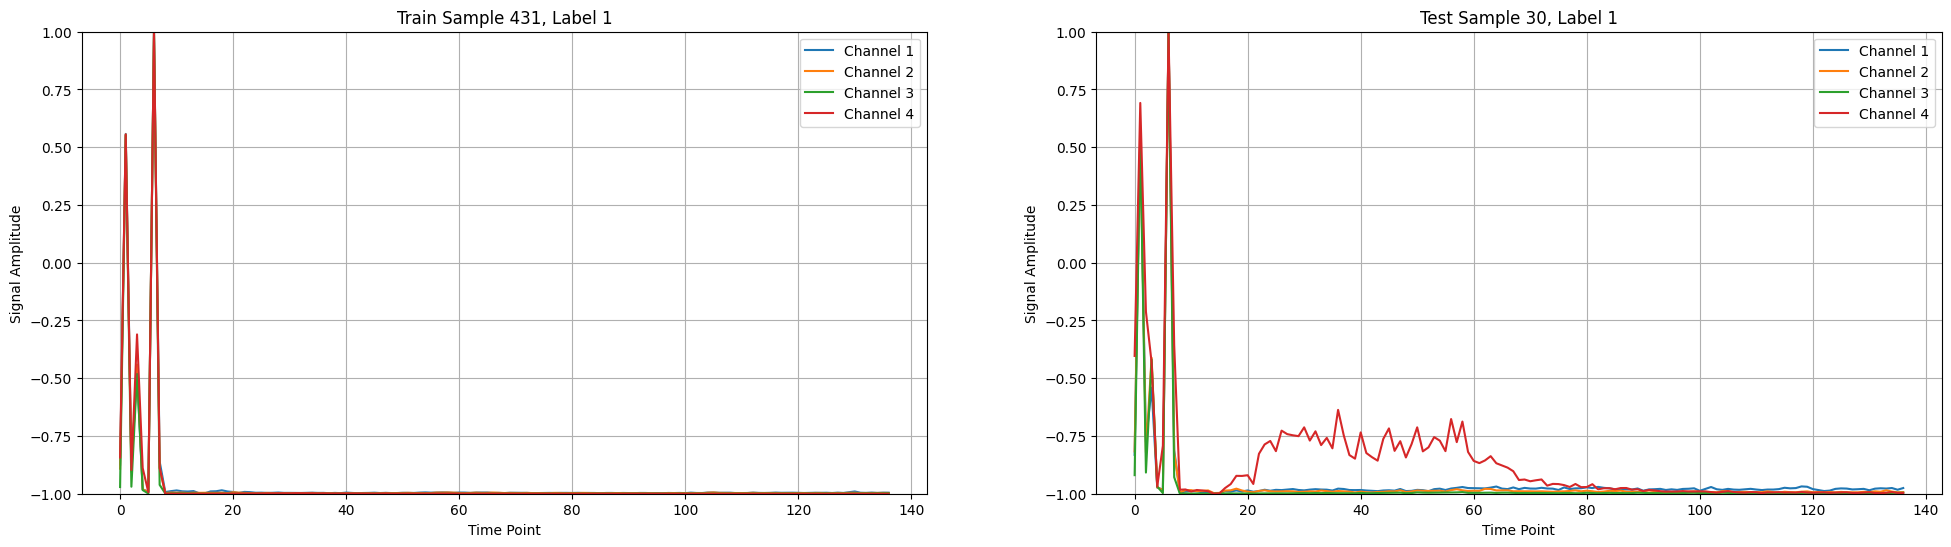

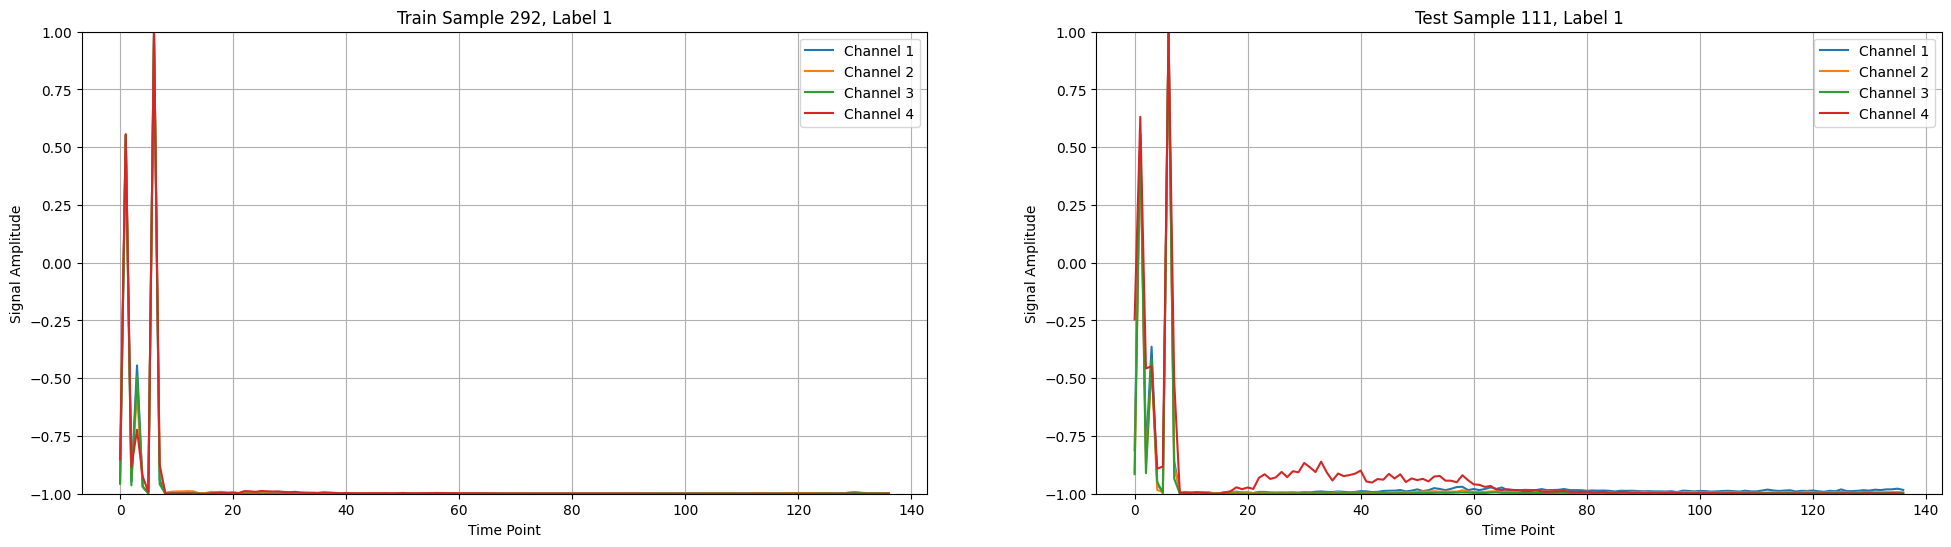

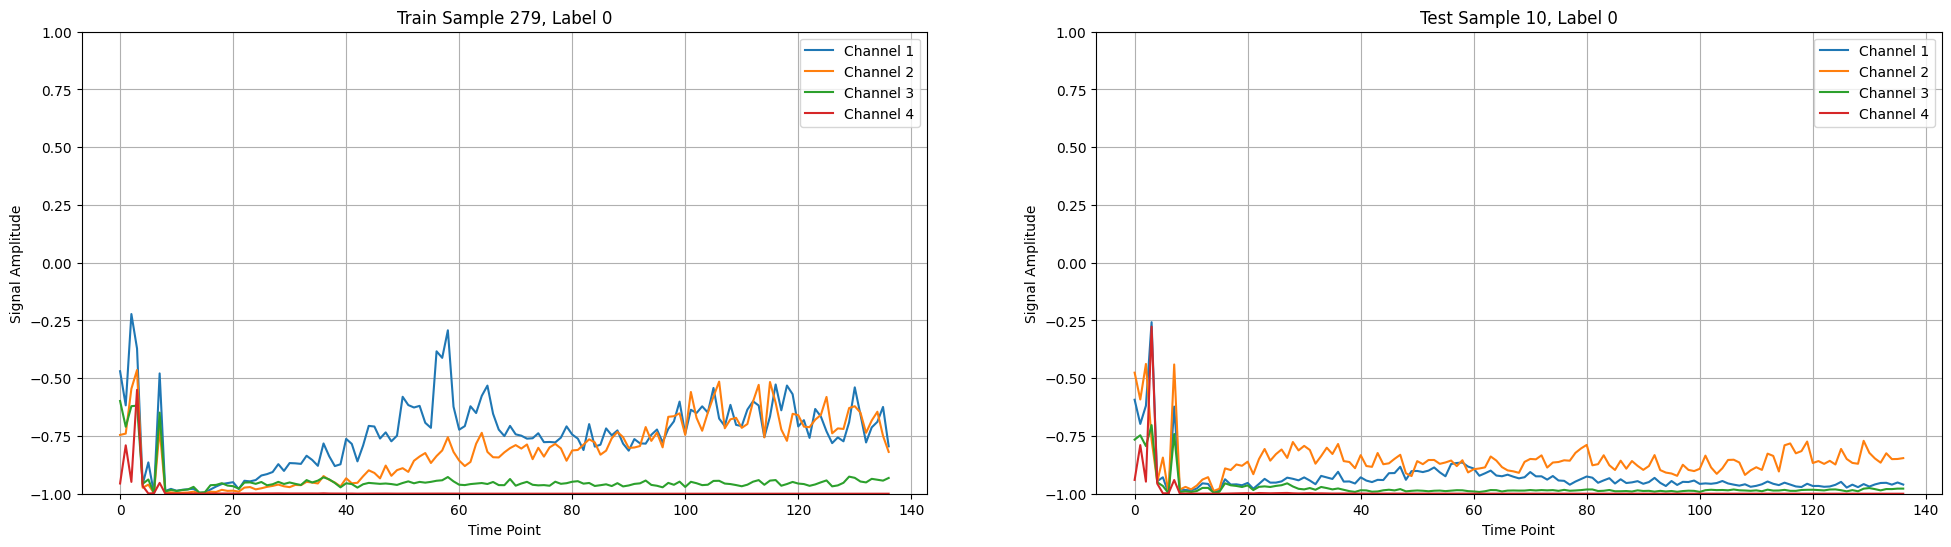

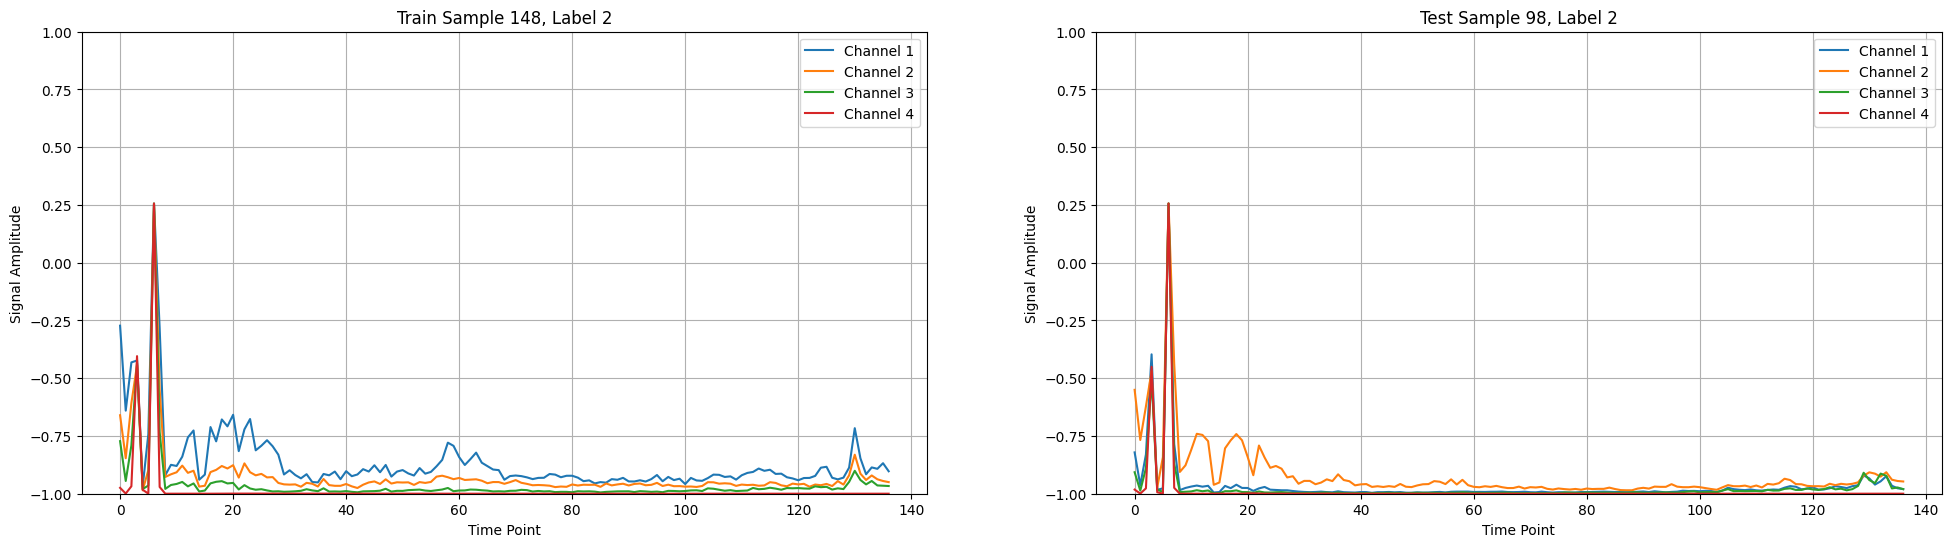

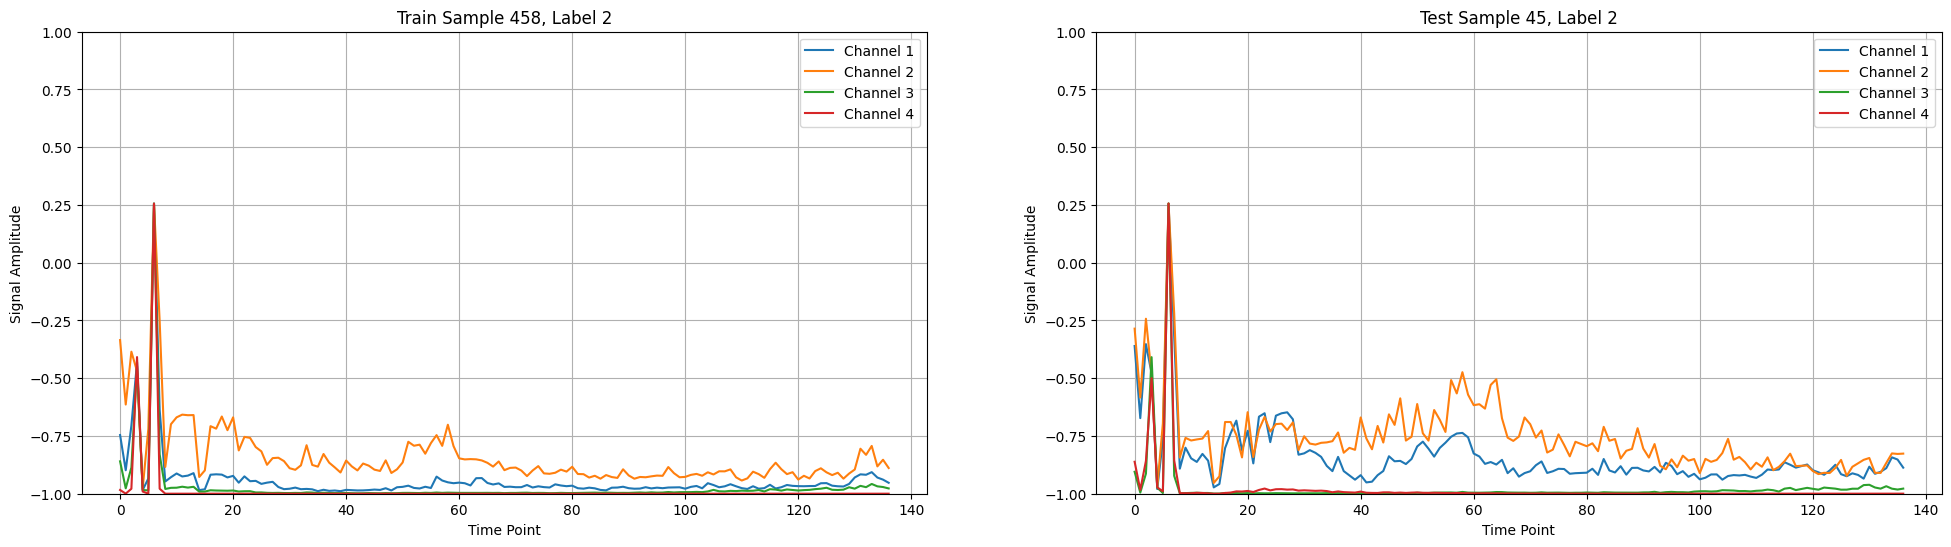

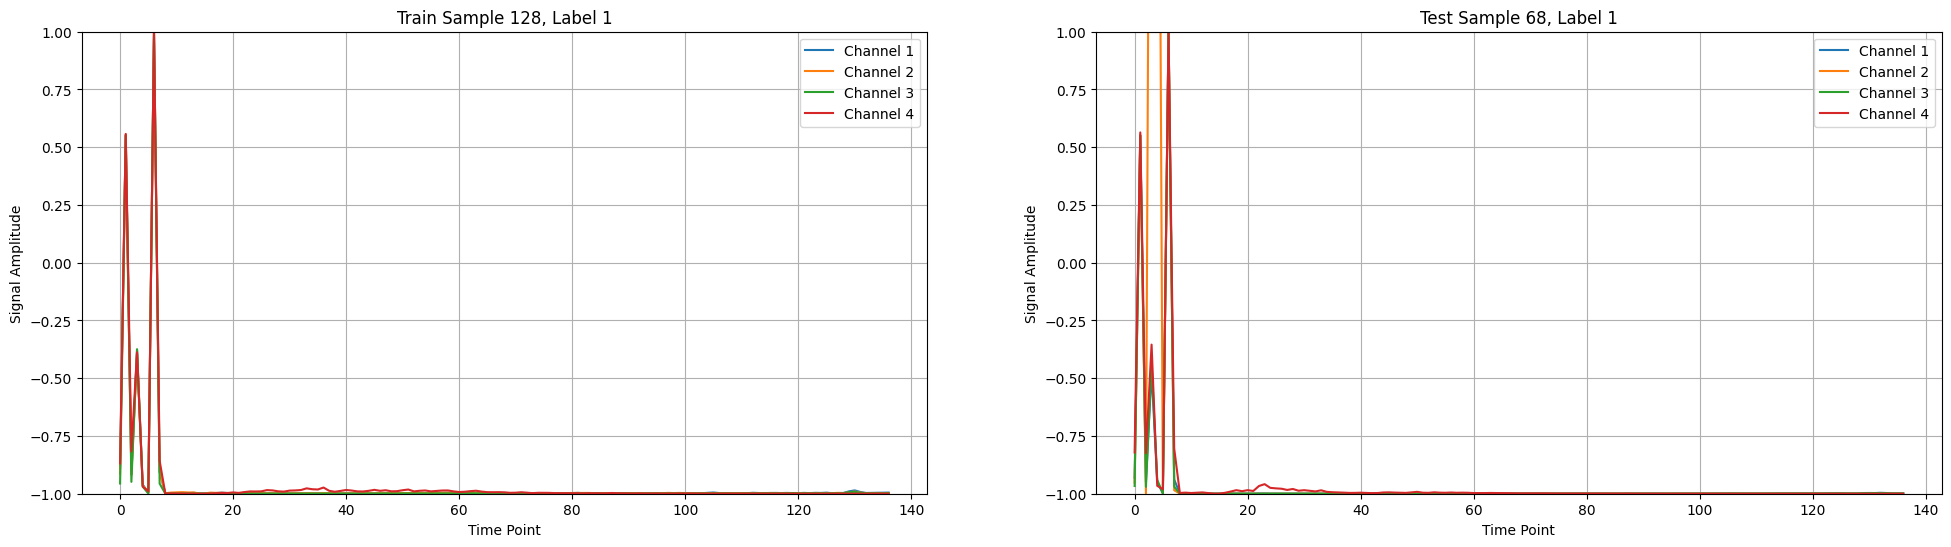

In [15]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, LayerNormalization, Reshape
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.backend import clear_session
from matplotlib.ticker import MultipleLocator
# features_array = np.load(file="features_array3.npy")
# GLOBAL_SHAPE_LENGTH = features_array.shape[1]
# scaler = StandardScaler()
# features_array = scaler.fit_transform(features_array)

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, LayerNormalization, Reshape
from keras.optimizers import Adam,SGD
from keras.metrics import categorical_crossentropy
from keras.backend import clear_session


e_features_array = np.load(file="ext_features_array.npy")
f_features_array = np.load(file="flex_features_array.npy")
r_features_array = np.load(file="rest_features_array.npy")
features_array = np.concatenate((e_features_array,f_features_array,r_features_array))


print(features_array.shape)
GLOBAL_SHAPE_LENGTH = features_array.shape[2]
ncomp = features_array.shape[1]
print(GLOBAL_SHAPE_LENGTH)

scaler = MinMaxScaler((-1,1))


X_train, X_test, y_train, y_test = train_test_split(features_array, label_array, test_size=.2, random_state=42, shuffle=True, stratify=label_array)
features_array  = scaler.fit_transform(features_array.reshape(-1, features_array.shape[-1])).reshape(features_array.shape)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
lst = y_train.tolist()
print(lst.count(0),lst.count(1),lst.count(2),GLOBAL_SHAPE_LENGTH)

lst = y_test.tolist()
print(lst.count(0),lst.count(1),lst.count(2),GLOBAL_SHAPE_LENGTH)

scaler = MinMaxScaler((-1,1))

X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

import numpy as np
import matplotlib.pyplot as plt

for _ in range(25):
    sample_index_train = random.randint(0, len(X_train) - 1)
    train_sample = X_train[sample_index_train]
    train_label = y_train[sample_index_train]

    match_indices = np.where(y_test == train_label)[0]
    sample_index_test = random.choice(match_indices)
    test_sample = X_test[sample_index_test]

    time_axis = np.arange(train_sample.shape[1])  # Time points on the x-axis

    plt.figure(figsize=(24, 6))

    # Plot train sample
    plt.subplot(1, 2, 1)
    for channel in range(train_sample.shape[0]):
        plt.plot(time_axis, train_sample[channel, :], label=f'Channel {channel+1}')
    plt.title(f"Train Sample {sample_index_train}, Label {train_label}")
    plt.xlabel("Time Point")
    plt.ylabel("Signal Amplitude")
    plt.ylim((-1, 1))
    plt.legend()
    plt.grid(True)

    # Plot test sample
    plt.subplot(1, 2, 2)
    for channel in range(test_sample.shape[0]):
        plt.plot(time_axis, test_sample[channel, :], label=f'Channel {channel+1}')
    plt.title(f"Test Sample {sample_index_test}, Label {y_test[sample_index_test]}")
    plt.xlabel("Time Point")
    plt.ylabel("Signal Amplitude")
    plt.ylim((-1, 1))
    plt.legend()
    plt.grid(True)

    plt.show()



In [16]:
class Plasticity(gym.Env):
    def __init__(self, images_per_episode=1, dataset=(X_train, y_train), random=True):
        super().__init__()

        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = gym.spaces.Box(low=-1, high=1,
                                                shape=(GLOBAL_SHAPE_LENGTH,ncomp),
                                                dtype=np.float32)
        self.images_per_episode = images_per_episode
        self.step_count = 0

        self.x, self.y = dataset
        self.random = random
        self.dataset_idx = 0

    def step(self, action):

        done = False
        reward = self.calculate_reward(action)

        obs = self._next_obs()

        self.step_count += 1
        if self.step_count >= self.images_per_episode:
            done = True

        return obs, reward, done, {}

    def reset(self):
        self.step_count = 0

        obs = self._next_obs()

        return obs
    
    def calculate_reward(self, action):
      if action == self.expected_action:
          reward = 1
          
      else:
          reward = 0

      return reward
    
    def _next_obs(self):
        if self.random:
            next_obs_idx = random.randint(0, len(self.x) - 1)
            self.expected_action = int(self.y[next_obs_idx])
            obs = self.x[next_obs_idx]


        else:
            obs = self.x[self.dataset_idx]
            self.expected_action = int(self.y[self.dataset_idx])

            self.dataset_idx += 1
            #print(f"Current dataset index: {self.dataset_idx}")
            if self.dataset_idx >= len(self.x):
                raise StopIteration()

        return obs

In [17]:
env = Plasticity()

In [18]:
env.observation_space.sample()
env.observation_space.sample().shape

(137, 4)

In [19]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.optimizers import Adam
tf.compat.v1.experimental.output_all_intermediates(True)

In [20]:
states = env.observation_space.shape
actions = env.action_space.n
print(states,actions)

(137, 4) 3


In [21]:
from keras.layers import PReLU, SpatialDropout1D, MaxPooling1D, GlobalMaxPooling1D, Layer, AveragePooling1D
from keras.regularizers import l1_l2
from tensorflow.keras.utils import register_keras_serializable
import keras.backend as K
@keras.saving.register_keras_serializable()
class LightweightLSTMAttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(LightweightLSTMAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(LightweightLSTMAttentionLayer, self).build(input_shape)

    def call(self, x):
        # Attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)

        # Apply the attention
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])
    
def build_model(states, actions):
    clear_session()
    model = Sequential([
        Reshape((GLOBAL_SHAPE_LENGTH,ncomp,),input_shape=(1,ncomp,GLOBAL_SHAPE_LENGTH)),
        BatchNormalization(),

        Conv1D(64, kernel_size=7),
        PReLU(),
        BatchNormalization(),

        MaxPooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        Conv1D(128, kernel_size=5),
        BatchNormalization(),
        PReLU(),
        AveragePooling1D(pool_size=2),
        SpatialDropout1D(0.1),

        LSTM(128, activation='tanh', recurrent_regularizer=l1_l2(l1=0.01, l2=0.01),return_sequences=True),
        BatchNormalization(),
        GlobalMaxPooling1D(),
        BatchNormalization(),
        Dense(units=128, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(units=actions, activation='linear')
    ])
    return model

In [22]:
import tensorflow as tf
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras import __version__
model = build_model(states, actions)
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 137, 4)            0         
                                                                 
 batch_normalization (Batch  (None, 137, 4)            16        
 Normalization)                                                  
                                                                 
 conv1d (Conv1D)             (None, 131, 64)           1856      
                                                                 
 p_re_lu (PReLU)             (None, 131, 64)           8384      
                                                                 
 batch_normalization_1 (Bat  (None, 131, 64)           256       
 chNormalization)                                                
                                                  

In [23]:
def build_agent(model, actions):
    policy = EpsGreedyQPolicy(eps=0.1)
    memory = SequentialMemory(limit=30000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-4)
    return dqn, policy

In [24]:
dqn, policy = build_agent(model, actions)
dqn.compile(tf.keras.optimizers.legacy.Adam(learning_rate=0.0055,decay=1e-4), metrics=['mse'])

In [25]:
from rl.callbacks import Callback

class LossHistory(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][0])

class LossHistory2(Callback):
    def __init__(self):
        self.losses = []

    def on_step_end(self, step, logs={}):
        self.losses.append(logs['metrics'][1])

class RewardHistory(Callback):
    def on_train_begin(self, logs={}):
        self.rewards = []

    def on_episode_end(self, episode, logs={}):
        self.rewards.append(logs['episode_reward'])

class ExponentialDecayEpsilonCallback(Callback):
    def __init__(self, initial_epsilon, min_epsilon, decay_rate, decay_steps):
        self.epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.step_count = 0

    def on_step_end(self, step, logs={}):
        self.step_count += 1
        self.epsilon = self.min_epsilon + (self.epsilon - self.min_epsilon) * np.exp(-self.step_count / self.decay_steps)
        self.model.policy.eps = max(self.epsilon, self.min_epsilon)
        #print(f"Step: {self.step_count}, New Epsilon: {self.epsilon}")



initial_epsilon = 1.0  
min_epsilon = 0.0 
decay_rate = 0.0001     
decay_steps = 100000    
epsilon_decay_cb = ExponentialDecayEpsilonCallback(initial_epsilon, min_epsilon, decay_rate, decay_steps)


loss_history = LossHistory()
loss_history2 = LossHistory2()
reward_history = RewardHistory()


dqn.fit(env, nb_steps=2000, callbacks=[loss_history,loss_history2,reward_history,epsilon_decay_cb], verbose=1)
dqn.policy.eps = 0
dqn.fit(env, nb_steps=200, callbacks=[loss_history,loss_history2,reward_history], verbose=1)
dqn.fit(env, nb_steps=200, callbacks=[loss_history,loss_history2,reward_history], verbose=1)

Training for 2000 steps ...
Interval 1 (0 steps performed)


c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python39_64\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


 2000/10000 [=====>........................] - ETA: 11:43 - reward: 0.8155done, took 176.154 seconds
Training for 200 steps ...
Interval 1 (0 steps performed)
  200/10000 [..............................] - ETA: 7:06 - reward: 1.0000done, took 8.700 seconds
Training for 200 steps ...
Interval 1 (0 steps performed)
  200/10000 [..............................] - ETA: 7:08 - reward: 0.9950done, took 8.757 seconds


In [26]:
class TestPhaseLogger(Callback):
    def __init__(self, env):
        
        self.env = env

    def on_action_end(self, action, logs={}):
       
        if not self.model.training and self.env.calculate_reward(action) > 0:
            print(f"Correct Action: {action}, Reward Gained")
        elif not self.model.training and self.env.calculate_reward(action) < 0:
            print(f"Wrong Action: {action}, Correct Action {self.env.y[self.env.dataset_idx-1]}, Penalty Incurred")
test_logger = TestPhaseLogger(env)

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from rl.policy import GreedyQPolicy
dqn.policy = GreedyQPolicy()

def dqn_eval(dqn_agent,d):
    attempts, correct = 0, 0
    labels = d[1]
    eenv = Plasticity(dataset=d, random=False)
    thing = 1
    y_predFull = []
    y_trueest = []
    total_reward = 0
    try:
        while True:
            if thing == 1:
                obs = eenv.reset()
                thing = 0
            done = False
            while not done:

                obs_reshaped = np.reshape(obs, (1,) + obs.shape)

                q_values = dqn_agent.compute_q_values(obs_reshaped)
                #print(q_values)

                action = np.argmax(q_values)
                
                #print('action: ', action, " - ", labels[attempts])
                y_predFull.append(action)
                y_trueest.append(labels[attempts])

                obs, rew, done, _ = eenv.step(action)
                if(rew == 2):
                    print(f"Correct Action: {action}, Reward Gained: {rew}")
                else:
                    print(f"Wrong Action: {action}, Correct Action {labels[attempts]}, Reward Gained: {rew}")
                total_reward += rew
                if done:
                    attempts += 1
    except StopIteration:
        print()
        print('Validation done...','total reward=',total_reward+1)

        y_predFull = np.array(y_predFull)
        y_trueest = np.array(y_trueest)

        cm = confusion_matrix(y_trueest, y_predFull)
        print(y_predFull)
        print(y_trueest)

        print("Confusion Matrix:\n", cm)

        report = classification_report(y_trueest, y_predFull,digits=4)
        print("Classification Report:\n", report)

        report = classification_report(y_trueest, y_predFull,output_dict=True)

        correct = sum(y_predFull == y_trueest)
        attempts = len(y_trueest)
        accuracy = (float(correct) / attempts)
        print('Validation done...')
        print('Accuracy: {:.2f}%'.format(accuracy*100))

        F1 = report['macro avg']['f1-score']
        precision = report['macro avg']['precision']
        recall = report['macro avg']['recall']

        print("F1 Score: {:.2f}%".format(F1*100))
        print("Precision: {:.2f}%".format(precision*100))
        print("Recall: {:.2f}%".format(recall*100))

    y_predFull = []
    y_trueest = []
    return accuracy, F1, precision, recall

dqn_eval(dqn,d=(X_train,y_train))
print('***************************************************************************************')
dqn_eval(dqn,d=(X_test,y_test))
print('***************************************************************************************')

def dqn_eval2(d,split=10):
     
    n_splits = split
    mean_rewards_per_fold = []
    acc_per_fold = []
    f1_mean, p_mean, r_mean = [], [], []
    # Loop over each fold
    
    skf = StratifiedKFold(n_splits=n_splits)
    train, test = d
    for train_index, test_index in skf.split(train,test):
        xtr, xte = train[train_index],train[test_index]
        ytr, yte = test[train_index], test[test_index]

        test_env = Plasticity(dataset = (xte, yte),random=True)
        
        scores = dqn.test(test_env, nb_episodes=10, visualize=False, verbose=0)
        acc, f1, p, r = dqn_eval(dqn,d=(xte, yte))
        
        mean_reward = np.mean(scores.history['episode_reward'])
        mean_rewards_per_fold.append(mean_reward)
        acc_per_fold.append(acc)
        f1_mean.append(f1)
        r_mean.append(r)
        p_mean.append(p)
   
    overall_mean_reward = np.mean(mean_rewards_per_fold)

    #print(acc_per_fold)
    
    f1_avg, p_avg, r_avg = np.mean(f1_mean), np.mean(p_mean), np.mean(r_mean)
    #print(mean_rewards_per_fold)
    print(f"Overall Mean Reward across all folds: {overall_mean_reward * 100} %")
    acc_avg = np.mean(acc_per_fold)
    print(f"Overall Mean Accuracy across all folds: {acc_avg * 100} %")
    #print(f1_mean)
    print(f"Overall Mean F1 across all folds: {f1_avg * 100} %")
    #print(p_mean)
    print(f"Overall Mean Precision across all folds: {p_avg * 100} %")
    #print(r_mean)
    print(f"Overall Mean Recall across all folds: {r_avg * 100} %")
#dqn_eval2(d=(X_train,y_train))

dqn_eval2(d=(features_array,label_array))
#dqn_eval(dqn,d=(features_array,label_array))

Wrong Action: 2, Correct Action 2, Reward Gained: 1


Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Actio

In [28]:

dqn_eval(dqn,d=(X_test,y_test))

Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 0, Correct Action 0, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 2, Correct Action 2, Reward Gained: 1
Wrong Action: 1, Correct Action 1, Reward Gained: 1
Wrong Action

(1.0, 1.0, 1.0, 1.0)

Testing for 30 episodes ...
Episode 1: reward: 1.000, steps: 1
Episode 2: reward: 1.000, steps: 1
Correct Action: 1, Reward Gained
Episode 3: reward: 1.000, steps: 1
Episode 4: reward: 1.000, steps: 1
Episode 5: reward: 1.000, steps: 1
Episode 6: reward: 1.000, steps: 1
Episode 7: reward: 1.000, steps: 1
Episode 8: reward: 1.000, steps: 1
Correct Action: 0, Reward Gained
Episode 9: reward: 1.000, steps: 1
Correct Action: 1, Reward Gained
Episode 10: reward: 1.000, steps: 1
Episode 11: reward: 1.000, steps: 1
Episode 12: reward: 1.000, steps: 1
Episode 13: reward: 1.000, steps: 1
Correct Action: 1, Reward Gained
Episode 14: reward: 1.000, steps: 1
Episode 15: reward: 1.000, steps: 1
Episode 16: reward: 1.000, steps: 1
Correct Action: 1, Reward Gained
Episode 17: reward: 1.000, steps: 1
Correct Action: 2, Reward Gained
Episode 18: reward: 1.000, steps: 1
Episode 19: reward: 1.000, steps: 1
Episode 20: reward: 1.000, steps: 1
Episode 21: reward: 1.000, steps: 1
Episode 22: reward: 1.000, 

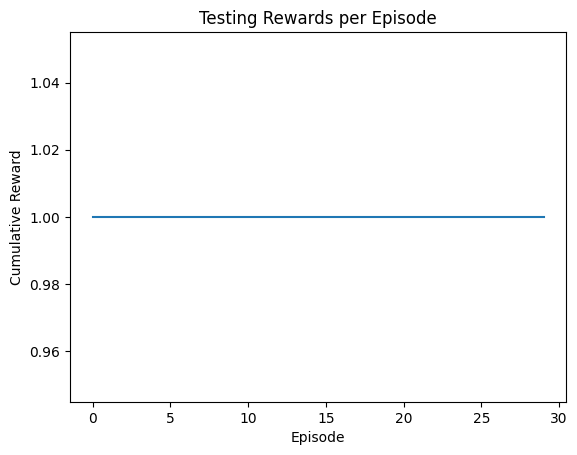

100.0 %
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 

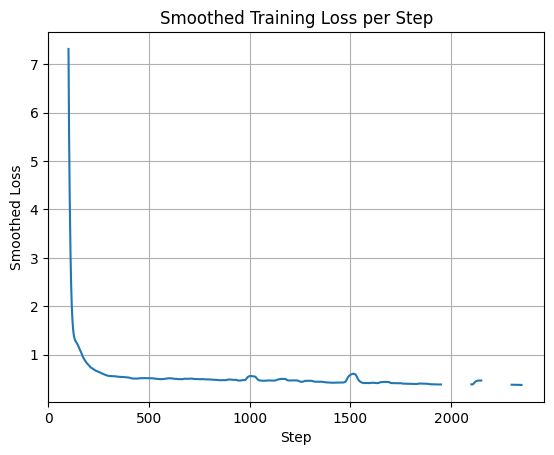

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.48600867, 0.4586041, 0.4413128, 0.4269071, 0.4152232, 0.40802723, 0.40236425, 0.395287, 0.38796183, 0.3822073, 0.37698188, 0.37233815, 0.3695045, 0.3659121, 0.36347044, 0.36209917, 0.3589808, 0.35642195, 0.35252458, 0.34781632, 0.34631777, 0.3434285, 0.34113938, 0.3408021, 0.33788446, 0.33585274, 0.33422348, 0.33235475, 0.33061686, 0.32775322, 0.3263206, 0.32485577, 0.32093444, 0.31826487, 0.31558916, 0.31332523, 0.3131942, 0.31166062, 0.31060117, 0.3107084, 0.30933142, 0.30676422, 0.306

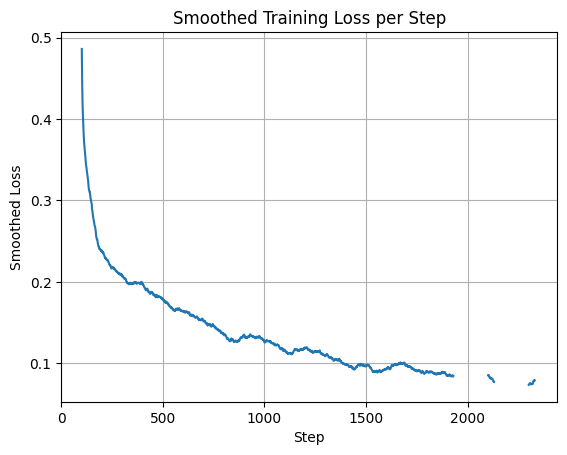

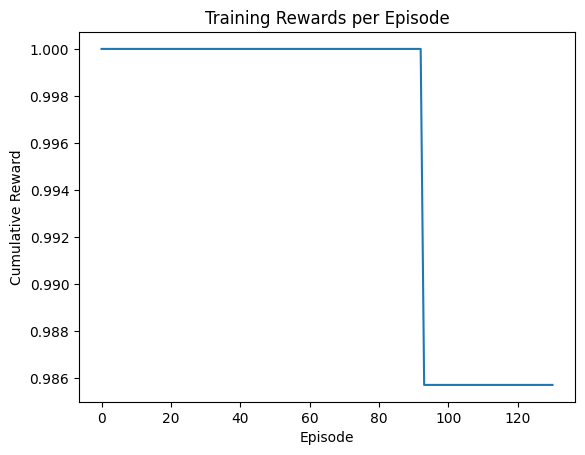

___________________________________________________________________________________________________________________________


In [29]:
scores = dqn.test(Plasticity(images_per_episode=1,random=True,dataset=(X_test,y_test)), callbacks=[test_logger],nb_episodes=30, visualize=False, action_repetition=1, verbose=1)
print(np.mean(scores.history['episode_reward'])*100,'%')
plt.plot(scores.history['episode_reward'])
plt.title('Testing Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()
print(np.mean(scores.history['episode_reward'])*100,'%')
print(label_array,label_array.shape)

dqn_eval(dqn,d=(features_array,label_array))
def moving_average(data, window_size):
    return [np.mean(data[i:i+window_size]) for i in range(len(data) - window_size + 1)]
losses = loss_history.losses
losses2 = loss_history2.losses
smoothed_losses = moving_average(losses, window_size=50)
print(smoothed_losses)
plt.plot(smoothed_losses)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

smoothed_losses2 = moving_average(losses2, window_size=70)
print(smoothed_losses2)
plt.plot(smoothed_losses2)
plt.title('Smoothed Training Loss per Step')
plt.xlabel('Step')
plt.xlim(left=0)
plt.ylabel('Smoothed Loss')
plt.grid(True)
plt.show()

plt.plot(moving_average(reward_history.rewards, window_size=70))
plt.title('Training Rewards per Episode')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.show()

print("___________________________________________________________________________________________________________________________")




